Outline

[Preliminary](#preliminary)<br>
[Clean & Merge](#clean--merge)<br>
[Feature engineering](#feature-engineering)<br>
[Graphical Analysis](#graphical-analysis)<br>
[Modelling](#modelling)<br>


# Preliminary

In [2]:
# import libraries
# ================

# for file and foler operations
import os
from glob import glob

# storing and analysing data
import numpy as np
import pandas as pd

# to handle timezone
from dateutil import tz

# for graphs
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Some functions for analysis
from helpers import *


In [3]:
# general settings
# ================

# better display options
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x if int(x) != x else '%d' % int(x))

# for convenient display of datasets
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

In [4]:
# Loading the data
# ================

# all files
data_directory = 'C:/Users/khalil/OneDrive - Deakin University/PhD Project/EVChallenge/RawFiles'

# consumption data
consumption_df = pd.concat(
    [pd.read_csv(file)
     for file in glob(f'{data_directory}/consumption*nov21*csv')],
    ignore_index=True
)

# power quality data
power_quality_df = pd.concat(
    [pd.read_csv(file)
     for file in glob(f'{data_directory}/power_quality*nov21*csv')],
    ignore_index=True
)

# Meters with EV
meters_with_ev_df = pd.read_excel(glob(f'{data_directory}/*meters*xlsx')[0])

display('consumption_df.head()', 'power_quality_df.head()',
        'meters_with_ev_df.head()')


consumption_df.head()
   Unnamed: 0  meter_id                          element_uuid  \
0           0    690991  025fbd27-87eb-4c5b-9d0c-f96c99022674   
1           1    690991  025fbd27-87eb-4c5b-9d0c-f96c99022674   
2           2    690991  025fbd27-87eb-4c5b-9d0c-f96c99022674   
3           3    690991  025fbd27-87eb-4c5b-9d0c-f96c99022674   
4           4    690991  025fbd27-87eb-4c5b-9d0c-f96c99022674   

     start_timestamptz_ts  active_consumption_kwh  active_generation_kwh  
0  2021-11-01 00:00:00+00                 0.06870                    NaN  
1  2021-11-01 00:30:00+00                 0.03750                    NaN  
2  2021-11-01 01:00:00+00                 0.06870                    NaN  
3  2021-11-01 01:30:00+00                 0.02500                    NaN  
4  2021-11-01 02:00:00+00                 0.09370                    NaN  

power_quality_df.head()
   Unnamed: 0  meter_id channel_cd                interval_ts  voltage_lvt  \
0           0    690991          a  2021-11-01 00:00:00+11:00    249.23000   
1           1    690991          a  2021-11-01 00:05:00+11:00    248.70000   
2           2    690991          a  2021-11-01 00:10:00+11:00    248.42000   
3           3    690991          a  2021-11-01 00:15:00+11:00    248.36000   
4           4    690991          a  2021-11-01 00:20:00+11:00    248.14000   

   amps_lct  power_factor_pf  number_of_phases overground_or_underground  
0   1.09137          0.99600                 1                        OH  
1   1.08735          0.99600                 1                        OH  
2   0.70296         -0.94600                 1                        OH  
3   0.70359         -0.94800                 1                        OH  
4   0.70296         -0.94600                 1                        OH  

meters_with_ev_df.head()
   Meter_ID EV Make             EV Model  EV wall charger installed?  \
0     14702    Tesla  Model 3 and Model X                        Yes   
1     21463   Nissan                 Leaf                         No   
2     63317  Nissan                  Leaf                         No   
3     69825  Jaguar                 ipace                        Yes   
4     98536   Jaguar                ipace                         No   

  How many kms do you usually drive each year? \n(prior to the COVID-19 pandemic)  \
0                                                             Greater than 20,000   
1                                                                 5,000 to 10,000   
2                                                                 5,000 to 10,000   
3                                                                10,000 to 15,000   
4                                                                15,000 to 20,000   

   kms_group  
0          5  
1          2  
2          2  
3          3  
4          4

In [5]:
# drop unnecessary columns
consumption_df = consumption_df.drop('Unnamed: 0', axis=1)
power_quality_df = power_quality_df.drop('Unnamed: 0', axis=1)

# Simple column names
def simple_col_name(col):
    col = col.lower().strip()
    return {'meter_id': 'meter',
            'start_timestamptz_ts': 'time',
            'interval_ts': 'time',
            'active_consumption_kwh': 'consumption',
            'active_generation_kwh': 'generation',
            'ev make': 'make',
            'ev model': 'model',
            "amps_lct": 'amps',
            'ev wall charger installed?': 'charger',
            'how many kms do you usually drive each year? \n(prior to the covid-19 pandemic)': 'drive_kms',
            'power_factor_pf': 'power_factor',
            'channel_cd': 'channel',
            'voltage_lvt': 'voltage',
            'number_of_phases': 'phases',
            'overground_or_underground': 'infrast',
            }.setdefault(col, col)

for df in consumption_df, power_quality_df, meters_with_ev_df:
    df.rename(columns=simple_col_name, inplace=True)


# TODO: delete later if not needed

# def generate_datetime_vars(df, to_create=None, timecol = 'time'):
#     """add useful datetime attributes to dataframe df"""
#     to_create = to_create or ['dayofyear', 'weekofyear', 'dayofweek', 'day', 'month', 'year']
#     datetime_accessor = df[timecol].dt
#     for col in to_create:
#         df[col] = getattr(datetime_accessor, col)
#     if 'dayofweek' in to_create:
#         df['weekend'] = np.where(df['dayofweek'] > 4, 1, 0)


In [11]:
# generate has_ev variable
meters_with_ev_df['has_ev'] = 1
meters_with_ev_df.head()


meter     make                model charger            drive_kms  \
0  14702    Tesla  Model 3 and Model X     Yes  Greater than 20,000   
1  21463   Nissan                 Leaf      No      5,000 to 10,000   
2  63317  Nissan                  Leaf      No      5,000 to 10,000   
3  69825  Jaguar                 ipace     Yes     10,000 to 15,000   
4  98536   Jaguar                ipace      No     15,000 to 20,000   

   kms_group  has_ev  
0          5       1  
1          2       1  
2          2       1  
3          3       1  
4          4       1

In [13]:
# fix time variable (to Melbourne timzone)
melbourne_tz = tz.gettz('Australia/Melbourne')
consumption_df['time'] = pd.to_datetime(consumption_df['time'], infer_datetime_format=True, utc=True).dt.tz_convert(melbourne_tz)
consumption_df = consumption_df.groupby(['meter', 'time']).sum().reset_index()
consumption_df['total_consumption'] = consumption_df[['consumption', 'generation']].sum(axis=1, skipna=True)
# merge with known EVs
consumption_df = pd.merge(left=consumption_df, right=meters_with_ev_df, on='meter', how='outer')
# has_ev
consumption_df['has_ev'] = consumption_df['has_ev'].fillna(0).astype('int')
# index
consumption_df.sort_values(['meter', 'time'], inplace=True, ignore_index=True)
# .drop_duplicates(subset=['meter', 'time'], keep=False).drop('element_uuid', axis=1)\
# .set_index(['time'])\
# .groupby('meter')\
# .resample('5T', closed='right', label='right')\
# .ffill().drop('meter', axis=1)
consumption_df.head()



meter                      time  consumption  generation  \
0    396 2021-11-01 11:00:00+11:00      0.04370           0   
1    396 2021-11-01 11:30:00+11:00      0.07500           0   
2    396 2021-11-01 12:00:00+11:00      0.11870           0   
3    396 2021-11-01 12:30:00+11:00      0.05620           0   
4    396 2021-11-01 13:00:00+11:00      0.04370           0   

   total_consumption make model charger drive_kms  kms_group  has_ev  
0            0.04370  NaN   NaN     NaN       NaN        NaN       0  
1            0.07500  NaN   NaN     NaN       NaN        NaN       0  
2            0.11870  NaN   NaN     NaN       NaN        NaN       0  
3            0.05620  NaN   NaN     NaN       NaN        NaN       0  
4            0.04370  NaN   NaN     NaN       NaN        NaN       0

In [14]:
# power quality datasets
# append & rename
# proper types
power_quality_df['time'] = pd.to_datetime(power_quality_df['time'], infer_datetime_format=True, utc=True).dt.tz_convert(
    melbourne_tz)
power_quality_df['abs_power_factor'] = np.abs(power_quality_df['power_factor'])
df_power_qualiyt = power_quality_df.query("phases == 3 | channel == 'a'")
power_quality_df = power_quality_df.set_index('time').groupby(['meter']).resample('30T').aggregate(
    {
        "voltage": "mean",
        "amps": "mean",
        "abs_power_factor": "mean",
        "phases": "first",
        "infrast": "first"
    }
).reset_index()
# 4generate_datetime_vars(power_quality_df)
obj_columns = power_quality_df.select_dtypes(include='object').columns
power_quality_df[obj_columns] = power_quality_df[obj_columns].astype('category')
# merge with known EVs
power_quality_df = pd.merge(left=power_quality_df, right=meters_with_ev_df, on='meter', how='outer')
power_quality_df['has_ev'] = power_quality_df['has_ev'].fillna(0).astype('int')
# sort
power_quality_df.sort_values(['meter', 'time'], inplace=True, ignore_index=True)
power_quality_df.head()


meter                      time   voltage    amps  abs_power_factor  \
0    396 2021-11-01 00:00:00+11:00 244.25000 0.41017           0.76867   
1    396 2021-11-01 00:30:00+11:00 245.63667 0.40637           0.68500   
2    396 2021-11-01 01:00:00+11:00 247.12000 0.41756           0.69583   
3    396 2021-11-01 01:30:00+11:00 246.76500 0.38138           0.62733   
4    396 2021-11-01 02:00:00+11:00 247.05667 0.37926           0.63083   

   phases infrast make model charger drive_kms  kms_group  has_ev  
0       1      OH  NaN   NaN     NaN       NaN        NaN       0  
1       1      OH  NaN   NaN     NaN       NaN        NaN       0  
2       1      OH  NaN   NaN     NaN       NaN        NaN       0  
3       1      OH  NaN   NaN     NaN       NaN        NaN       0  
4       1      OH  NaN   NaN     NaN       NaN        NaN       0

# Feature engineering

The Correlation between the number of times within a month the meter consumption exceeded different percentiles of consumption and probability of having EV

In [11]:
df_consumption_for_features = df_consumption.copy()
corr = []
perc = []
for q in range(50, 100, 5):
    df_consumption_for_features[f'cons_above_{q}'] = np.where(
        df_consumption_for_features['consumption'] > df_consumption_for_features['consumption'].quantile(q/100), 1, 0
        )
    aggregations = {
        f'cons_above_{q}': 'sum',
        'has_ev': 'last'
    }
    numeric_features = df_consumption_for_features.select_dtypes(exclude='object').columns
    agg_cons = df_consumption_for_features[numeric_features].reset_index().groupby('meter').aggregate(aggregations)
    corr.append(agg_cons.corr().loc['has_ev', f'cons_above_{q}'])
    perc.append(q)
# del df_consumption_for_features
pd.Series(corr, index=perc)

50   0.13239
55   0.13885
60   0.14044
65   0.14847
70   0.15532
75   0.16472
80   0.17398
85   0.17611
90   0.17110
95   0.19223
dtype: float64

The Correlation between the number of times within a month the meter current (amps) exceeded different percentiles of current and probability of having EV

In [12]:
df_power_quality_for_features = df_power_quality.copy()
corr = []
perc = []
for q in range(50, 100, 5):
    df_power_quality_for_features[f'amps_above_{q}'] = np.where(
        df_power_quality_for_features['amps'] > df_power_quality_for_features['amps'].quantile(q/100), 1, 0
        )
    aggregations = {
        f'amps_above_{q}': 'sum',
        'has_ev': 'last'
    }
    numeric_features = df_power_quality_for_features.select_dtypes(exclude='object').columns
    agg_amps = df_power_quality_for_features[numeric_features].reset_index().groupby('meter').aggregate(aggregations)
    corr.append(agg_amps.corr().loc['has_ev', f'amps_above_{q}'])
    perc.append(q)
# del df_power_quality_for_features
pd.Series(corr, index=perc)

50   0.12267
55   0.13584
60   0.13963
65   0.14257
70   0.14439
75   0.14278
80   0.14367
85   0.13330
90   0.13397
95   0.15315
dtype: float64

# Graphical Analysis

Helper functions

In [13]:
df_consumption_for_plots = df_consumption.copy().set_index(['meter', 'time'])
df_power_quality_for_plots = df_power_quality.copy().set_index(['meter', 'time'])
def subset_by_meter(meter_id: int, start: str, end: str, cols=None, cons_for_plots=None, quality_for_plots=None):
    """plot cols from cons_for_plots, quality_for_plots; both should be indexed by meter and time. That for specific meter from start to end"""
    # ensure start and end dates are within dataset range
    cols = cols or ['consumption', 'amps']

    cons_for_plots = cons_for_plots or df_consumption_for_plots
    quality_for_plots = quality_for_plots or df_power_quality_for_plots

    min_date, max_date = df_consumption_for_plots.reset_index()['time'][[0, len(df_consumption_for_plots) - 1]]
    start = max(pd.to_datetime(start).tz_localize(melbourne_tz), min_date)
    end = min(pd.to_datetime(end).tz_localize(melbourne_tz), max_date)

    df1 = df_consumption_for_plots.loc[pd.IndexSlice[meter_id, start:end], :].droplevel('meter')
    df2 = df_power_quality_for_plots.loc[pd.IndexSlice[meter_id, start:end], :].droplevel('meter')
    return pd.merge(left=df1, right=df2, left_index=True, right_index=True, how='left')[cols]


def plot_subplots_common_x(meter_data, hours_interval: int | None = None) -> None:
    """plot meter_data (better call this with output from subset_by_meter)"""
    fig, axes = plt.subplots(2, 1, figsize=(30, 12))
    # plot at a time
    for col, ax in zip(meter_data.columns, axes):
        meter_data[col].plot(ax=ax, subplots=True, x_compat=True)
        ax.set_title(col.title())
        ax.set_xlabel("")
        # X axis labels
        date_locator = mdates.DayLocator(interval=1)
        date_form = mdates.DateFormatter("%m-%d")
        ax.xaxis.grid(True, which='major', color='gray')
        ax.xaxis.set_major_locator(date_locator)
        ax.xaxis.set_major_formatter(date_form)
        ax.tick_params(axis='x', which='major', pad=20)
        if hours_interval is not None:
            hour_locator = mdates.HourLocator(interval=hours_interval)
            hour_form = mdates.DateFormatter("%H")
            ax.xaxis.set_minor_locator(hour_locator)
            ax.xaxis.set_minor_formatter(hour_form)

def plot_consumption_amps(meter, start='2021-11-15', end='2021-11-30', hours_interval=12, verbose=True):
    meter_data = subset_by_meter(meter_id=meter, start=start, end=end)
    if verbose:
        meter_info = df_with_ev[df_with_ev['meter'] == meter]
        if not meter_info.empty:
            print(meter_info)
        else:
            print('meter has no EV')

    
    fig = plot_subplots_common_x(meter_data, hours_interval=hours_interval)


Consumption and current for meters with EV between 15th and 30th November 2021

   meter   make                model charger            drive_kms  has_ev
0  14702  Tesla  Model 3 and Model X     Yes  Greater than 20,000       1


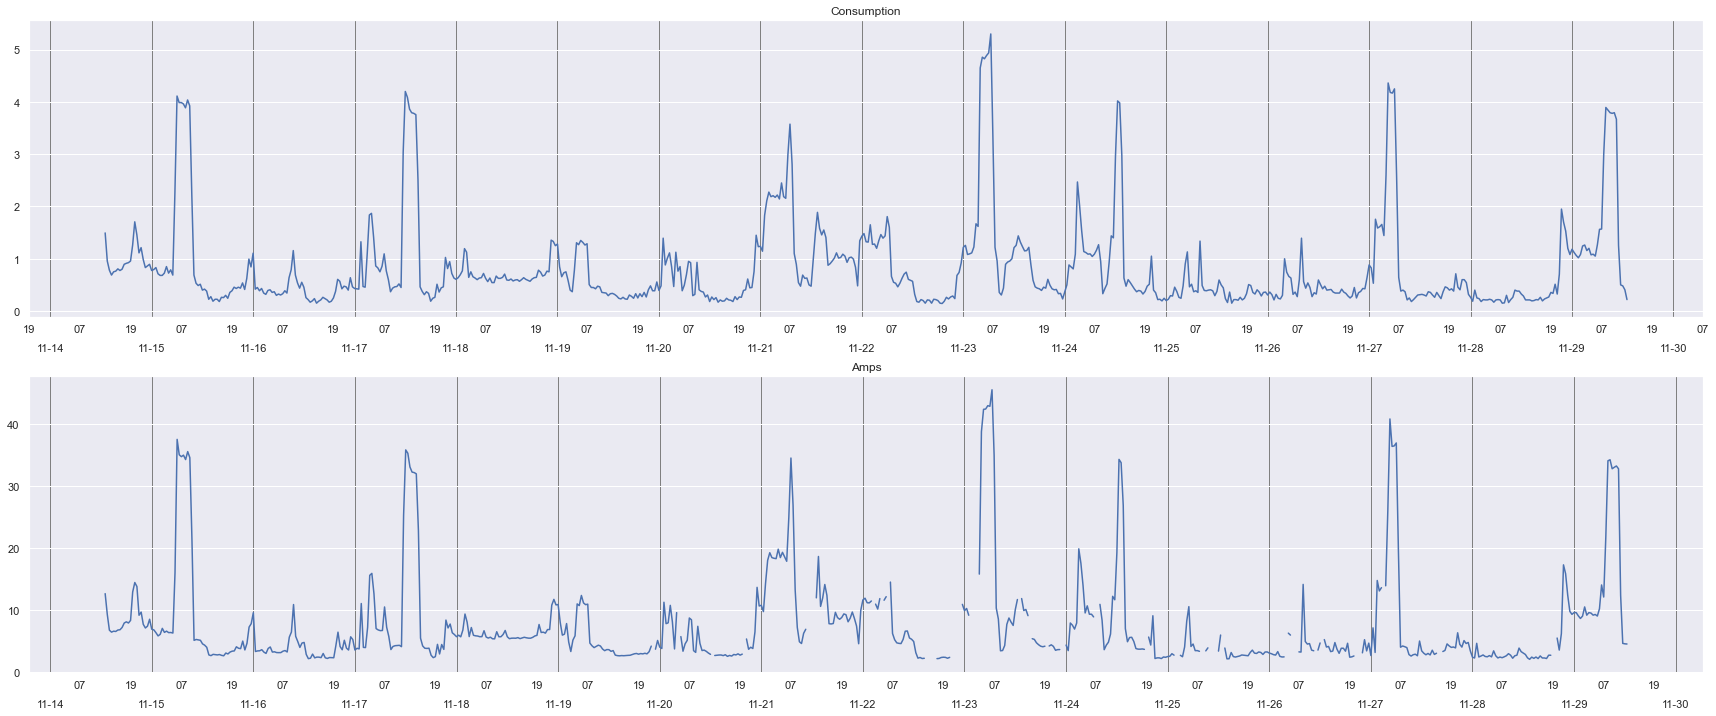

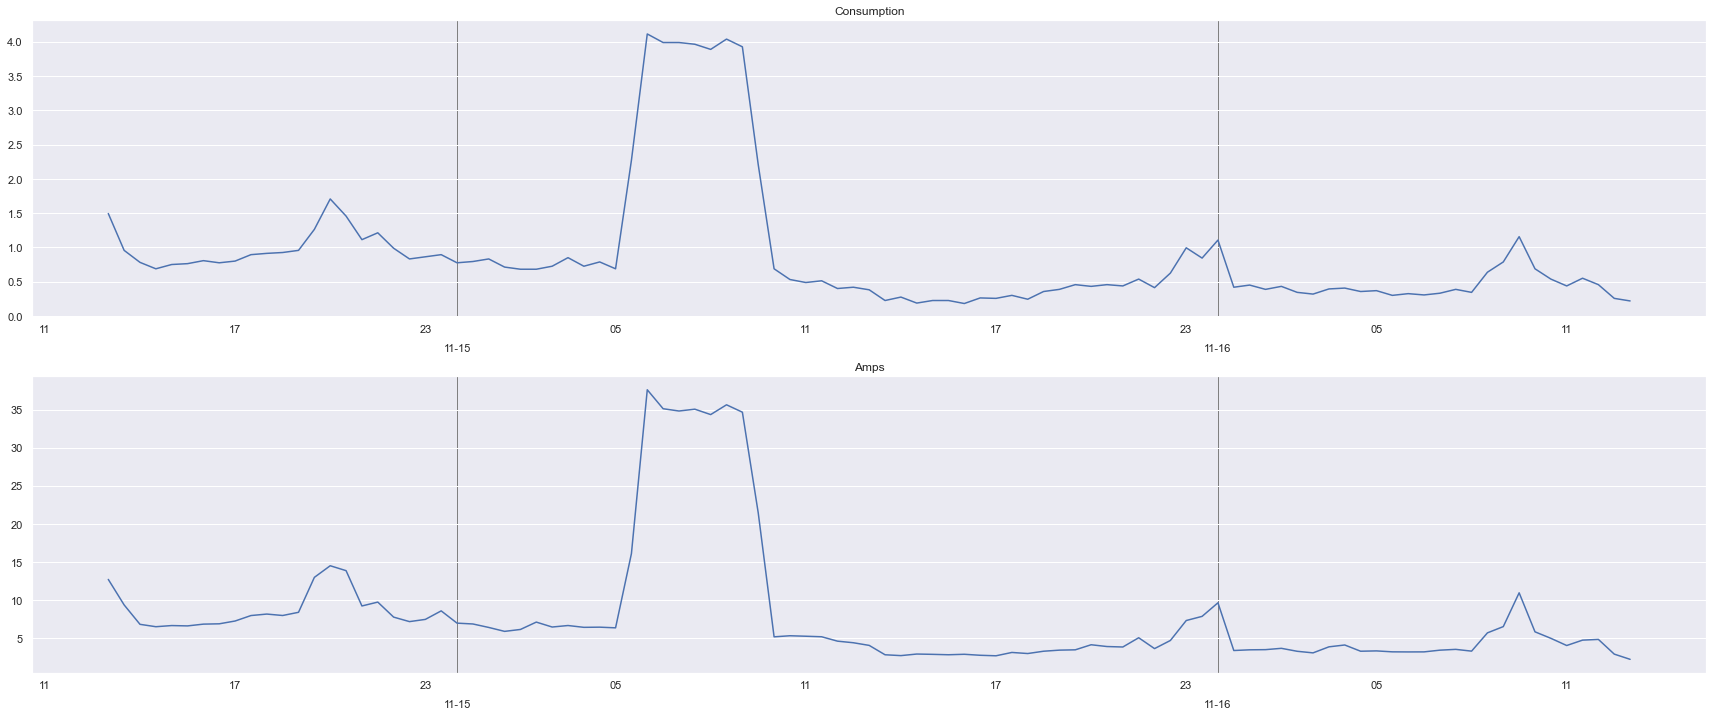

In [14]:
plot_consumption_amps(meter=meters_with_ev[0])
## example of customized plot
plot_consumption_amps(meter=meters_with_ev[0], start='2021-11-15', end='2021-11-17', hours_interval=6, verbose=False)

   meter    make model charger        drive_kms  has_ev
1  21463  Nissan  Leaf      No  5,000 to 10,000       1


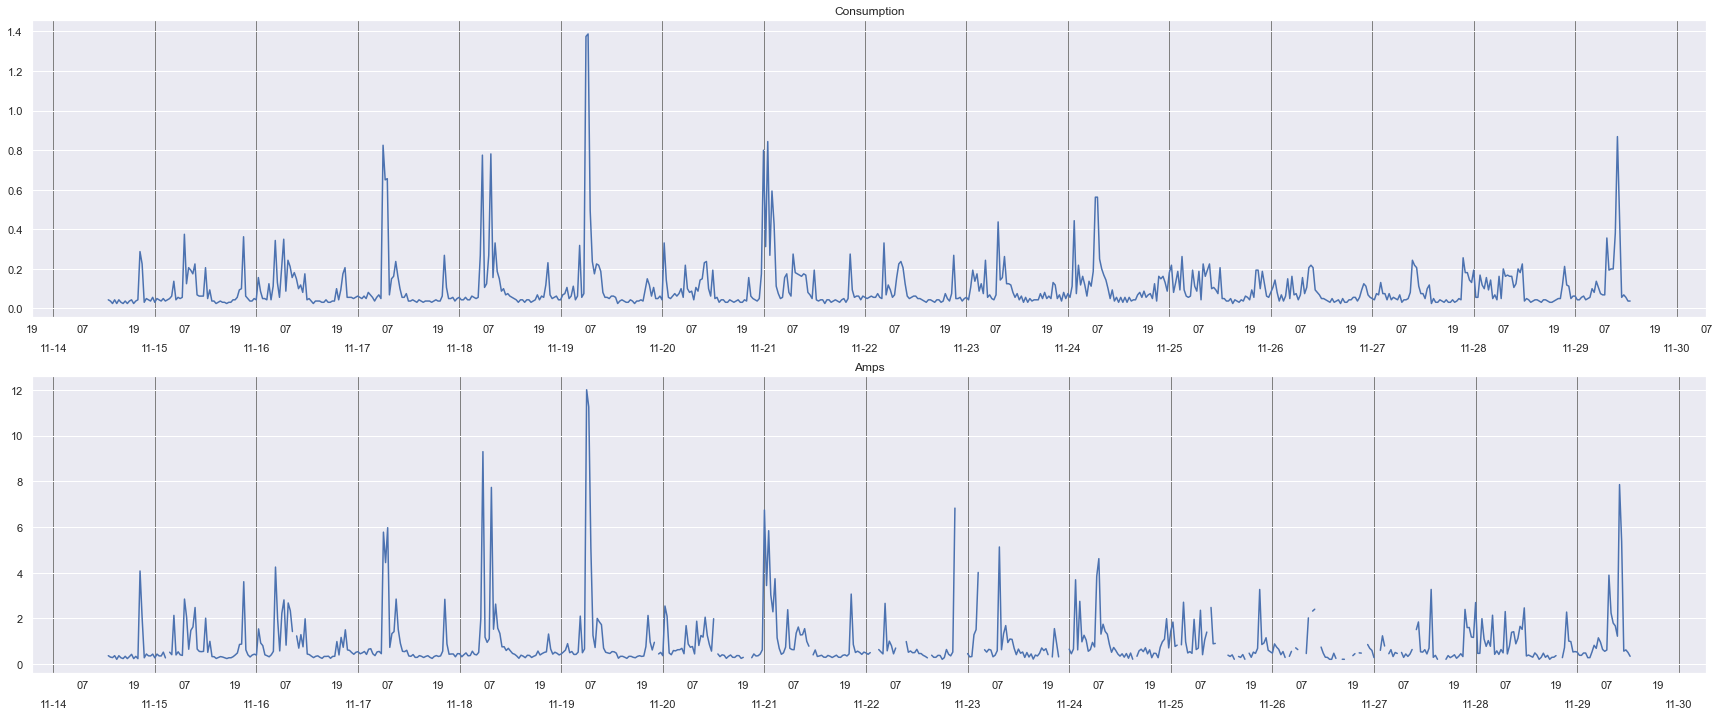

In [15]:
plot_consumption_amps(meter=meters_with_ev[1])

   meter     make model charger        drive_kms  has_ev
2  63317  Nissan   Leaf      No  5,000 to 10,000       1


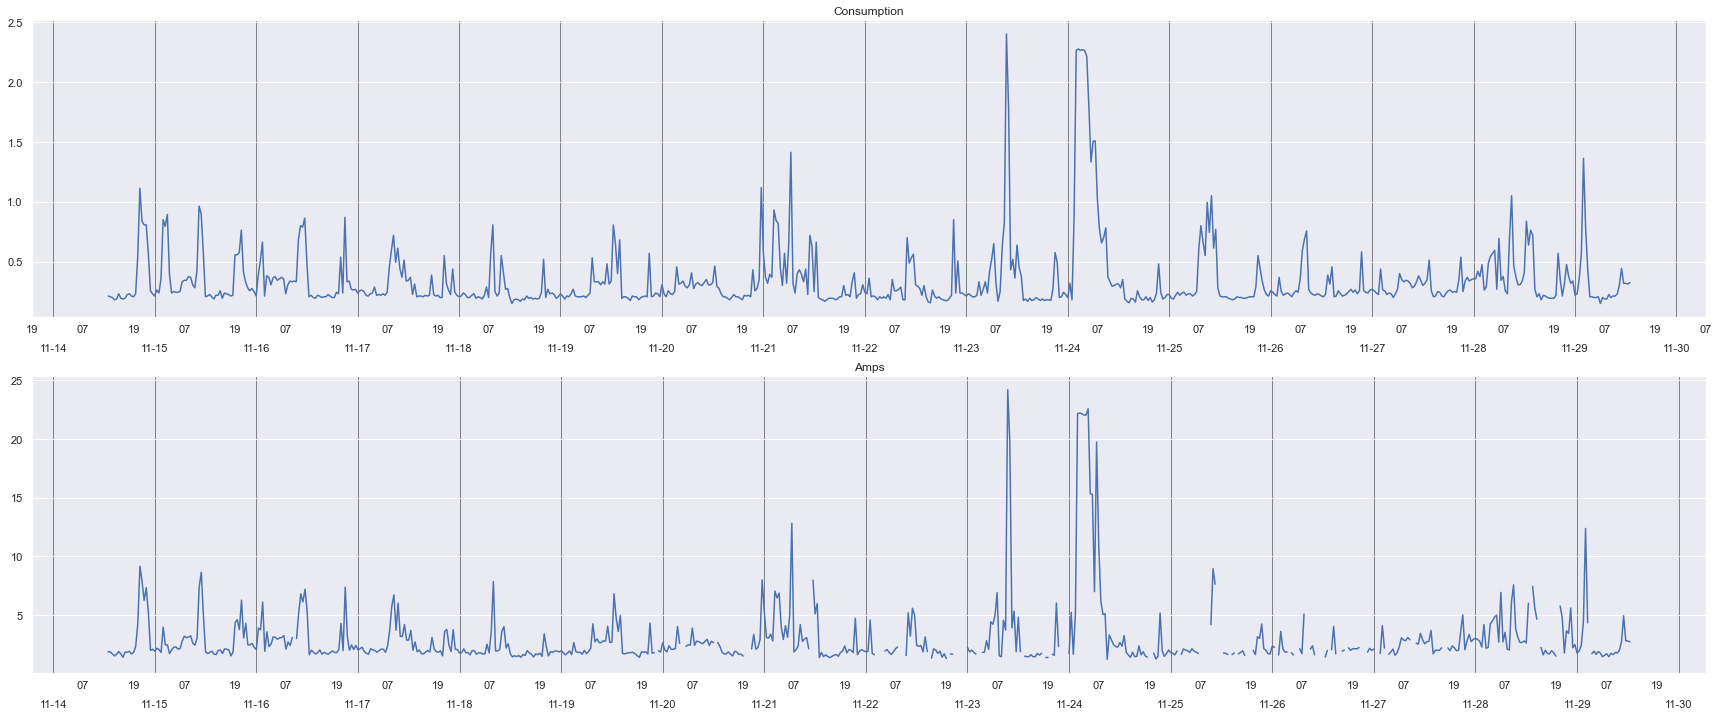

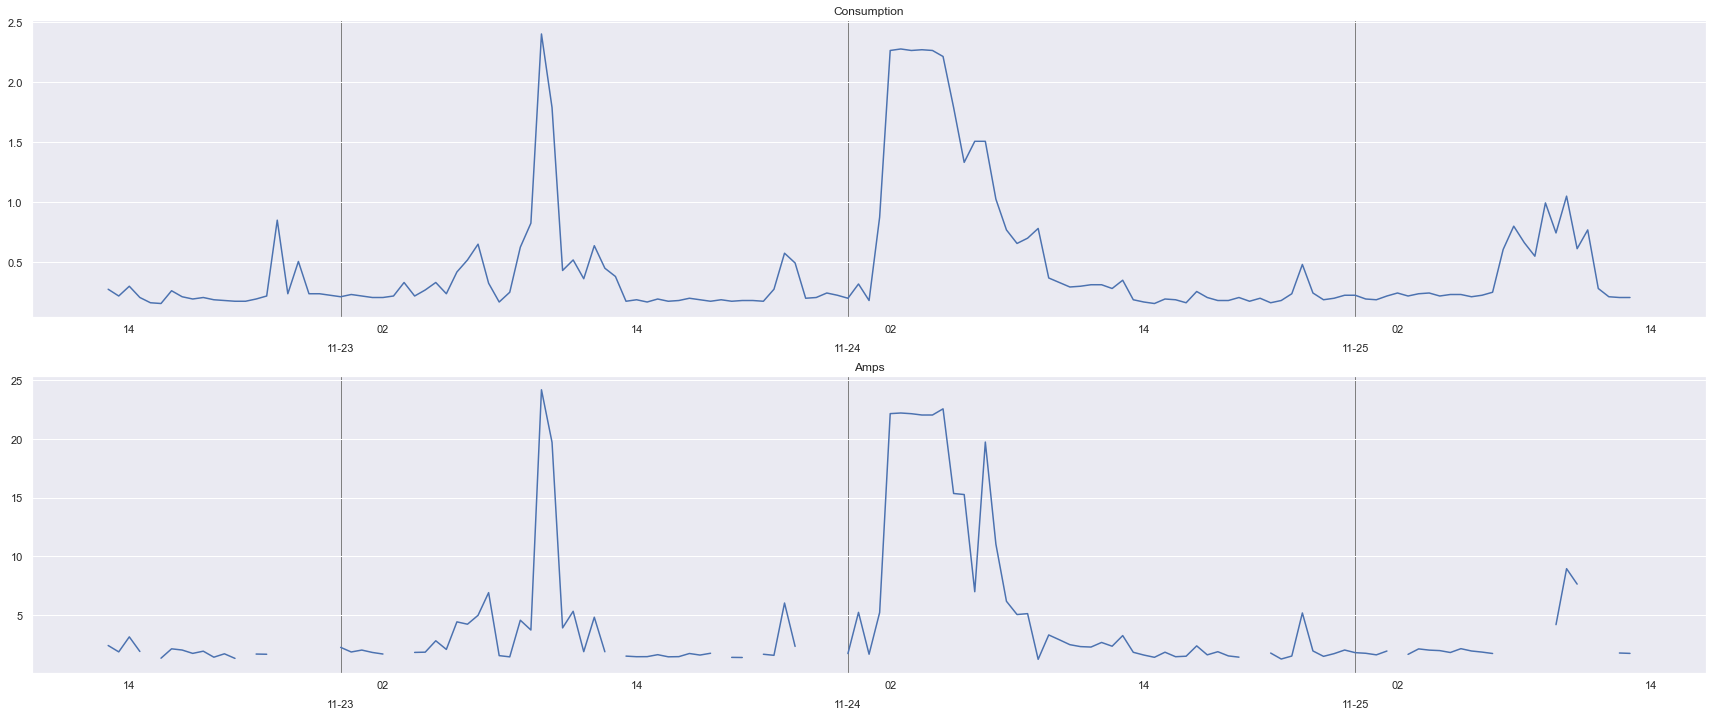

In [16]:
plot_consumption_amps(meters_with_ev[2])
plot_consumption_amps(meters_with_ev[2], start='2021-11-23', end='2021-11-26', verbose=False)

   meter     make  model charger         drive_kms  has_ev
3  69825  Jaguar   ipace     Yes  10,000 to 15,000       1


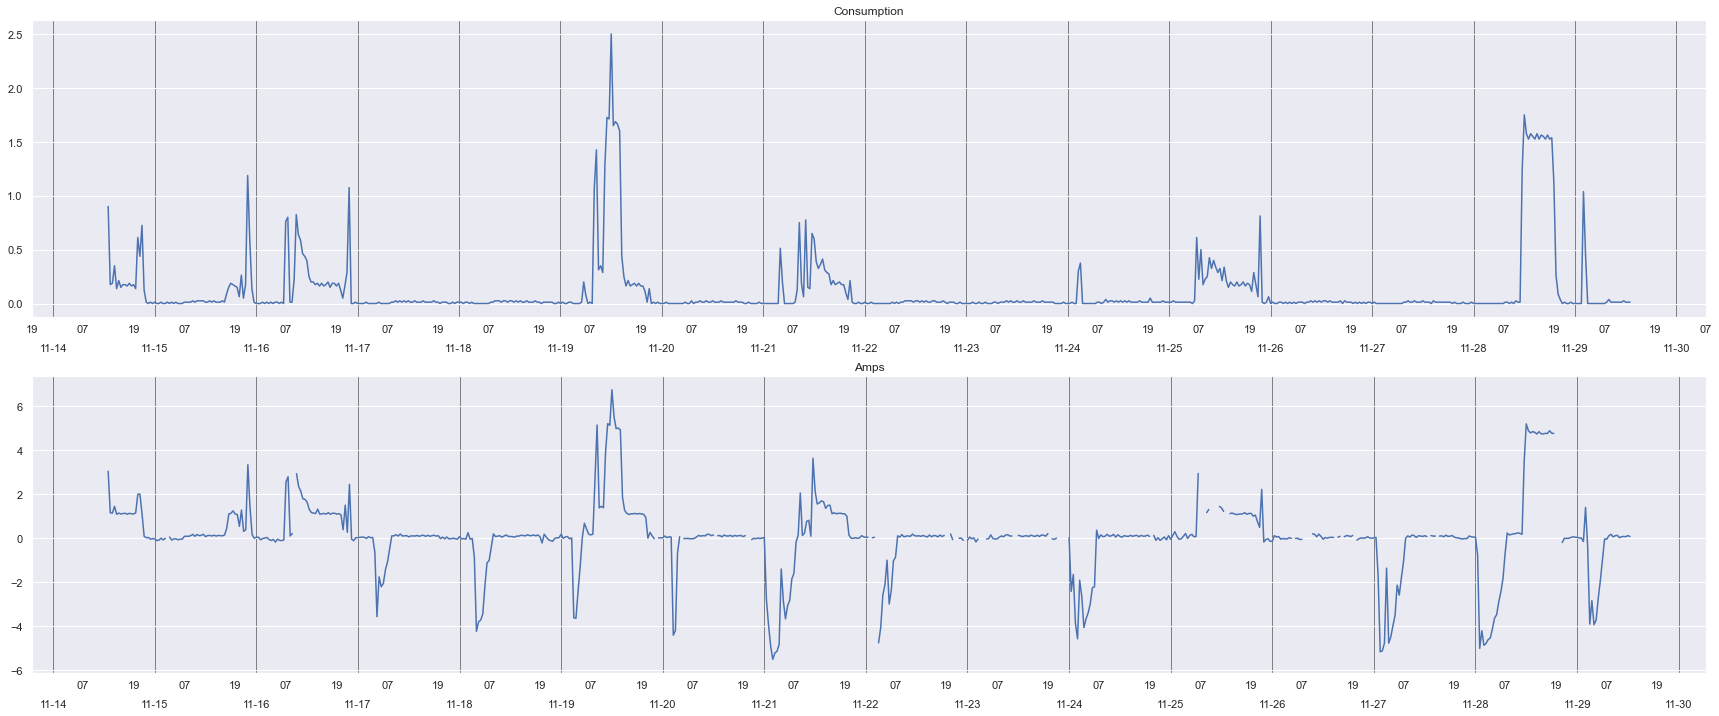

In [17]:

plot_consumption_amps(meters_with_ev[3])

   meter    make  model charger         drive_kms  has_ev
4  98536  Jaguar  ipace      No  15,000 to 20,000       1


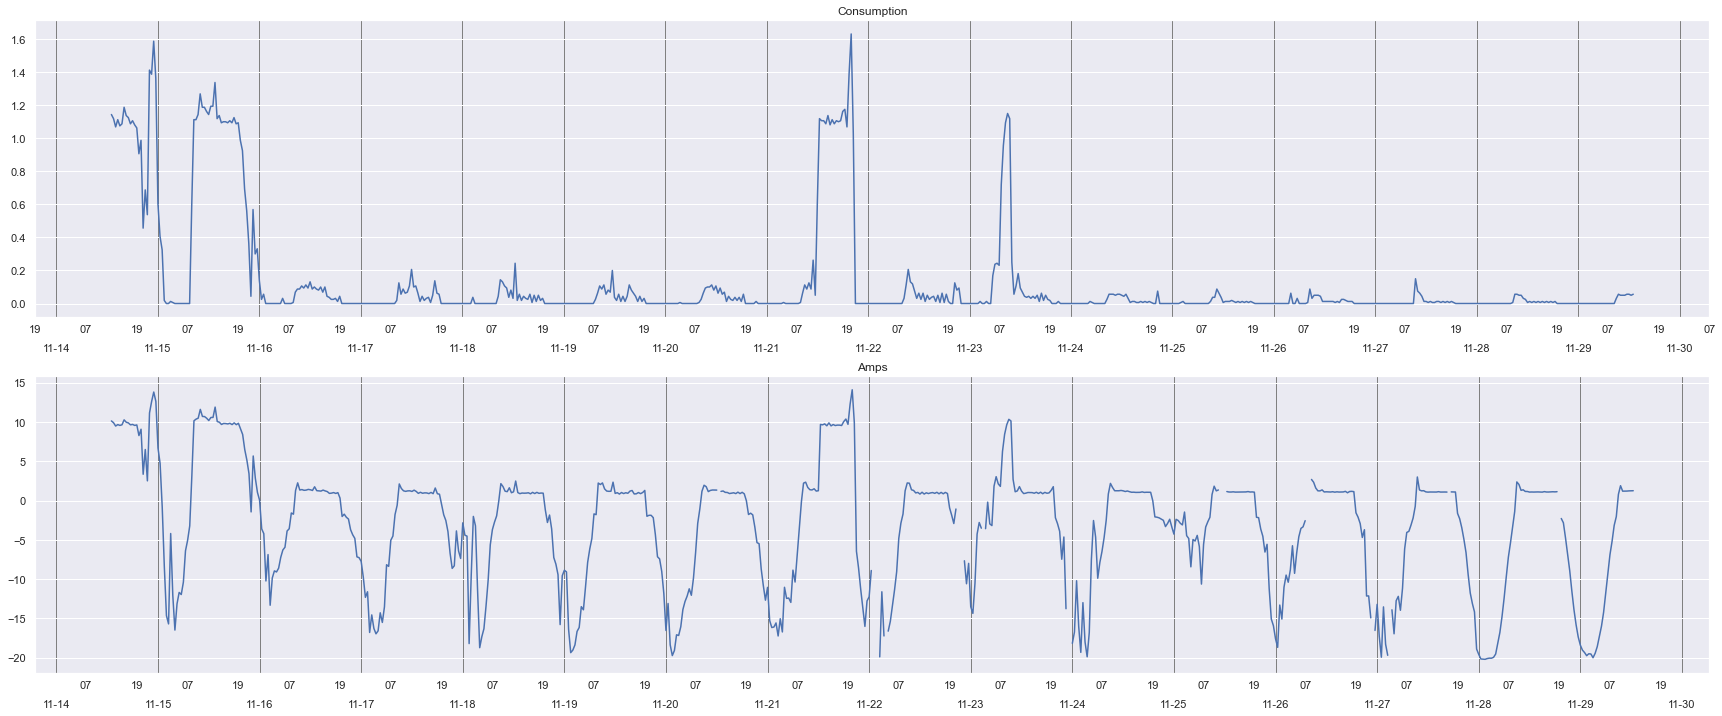

In [18]:
plot_consumption_amps(meters_with_ev[4])

    meter   make             model charger        drive_kms  has_ev
5  102145  Tesla  Model S, Model 3     Yes  5,000 to 10,000       1


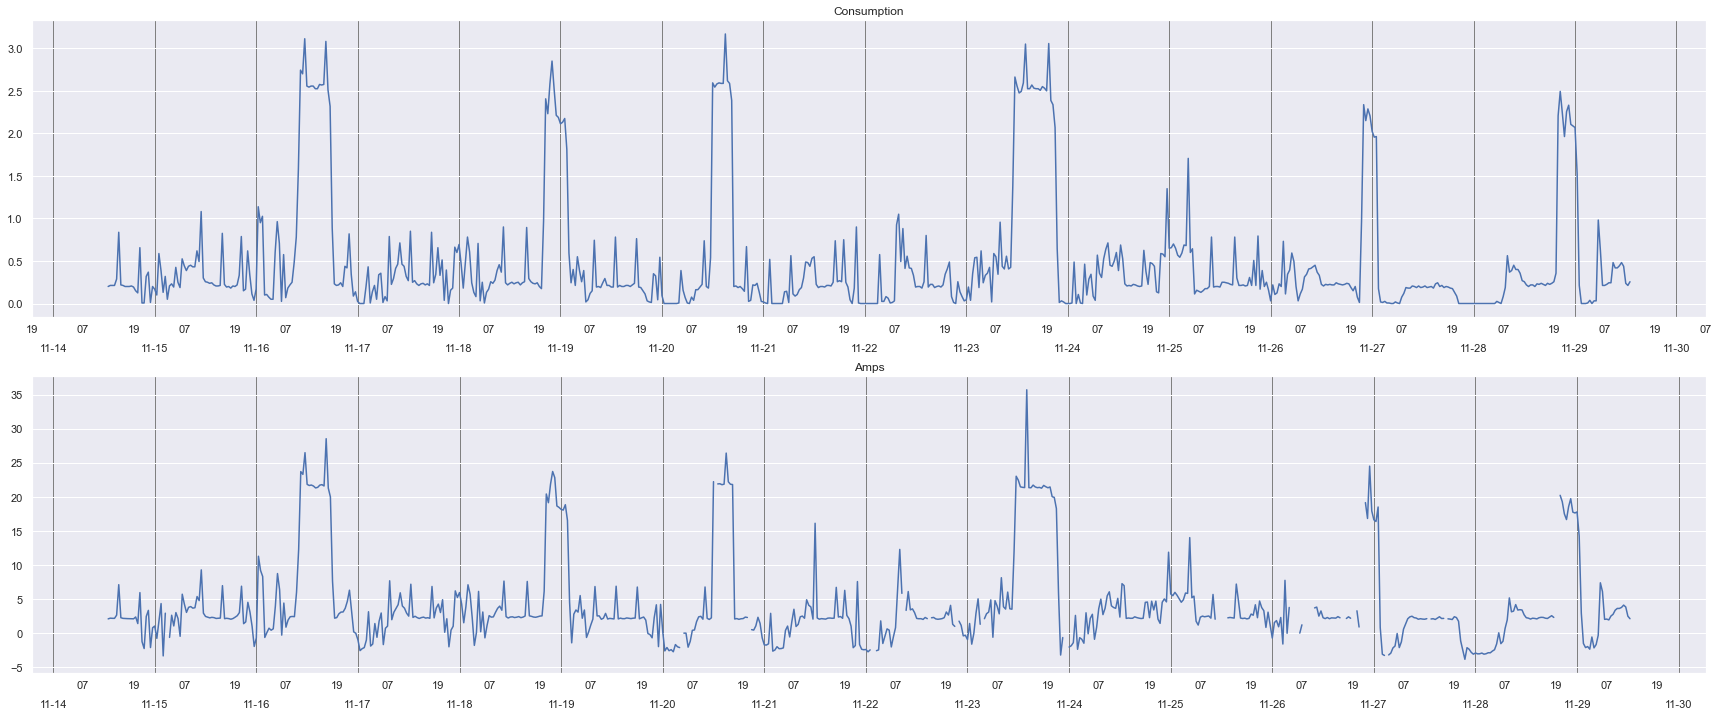

In [19]:
plot_consumption_amps(meters_with_ev[5])

    meter     make  model charger         drive_kms  has_ev
6  109154  Hyundai  Ioniq     Yes  10,000 to 15,000       1


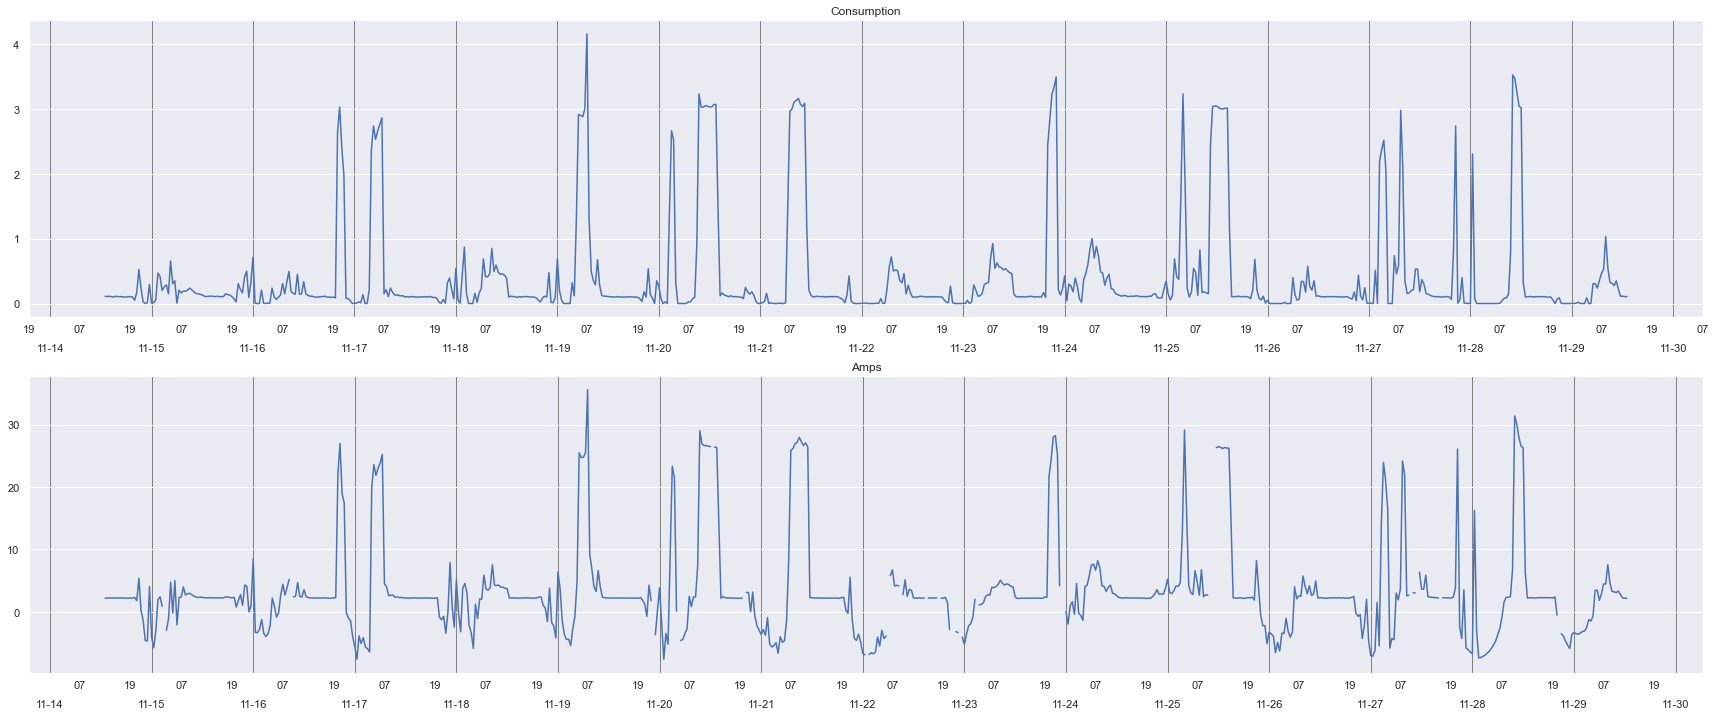

In [20]:
plot_consumption_amps(meters_with_ev[6])

    meter     make   model charger        drive_kms  has_ev
7  120889  Renault  Zoe 40     Yes  5,000 to 10,000       1


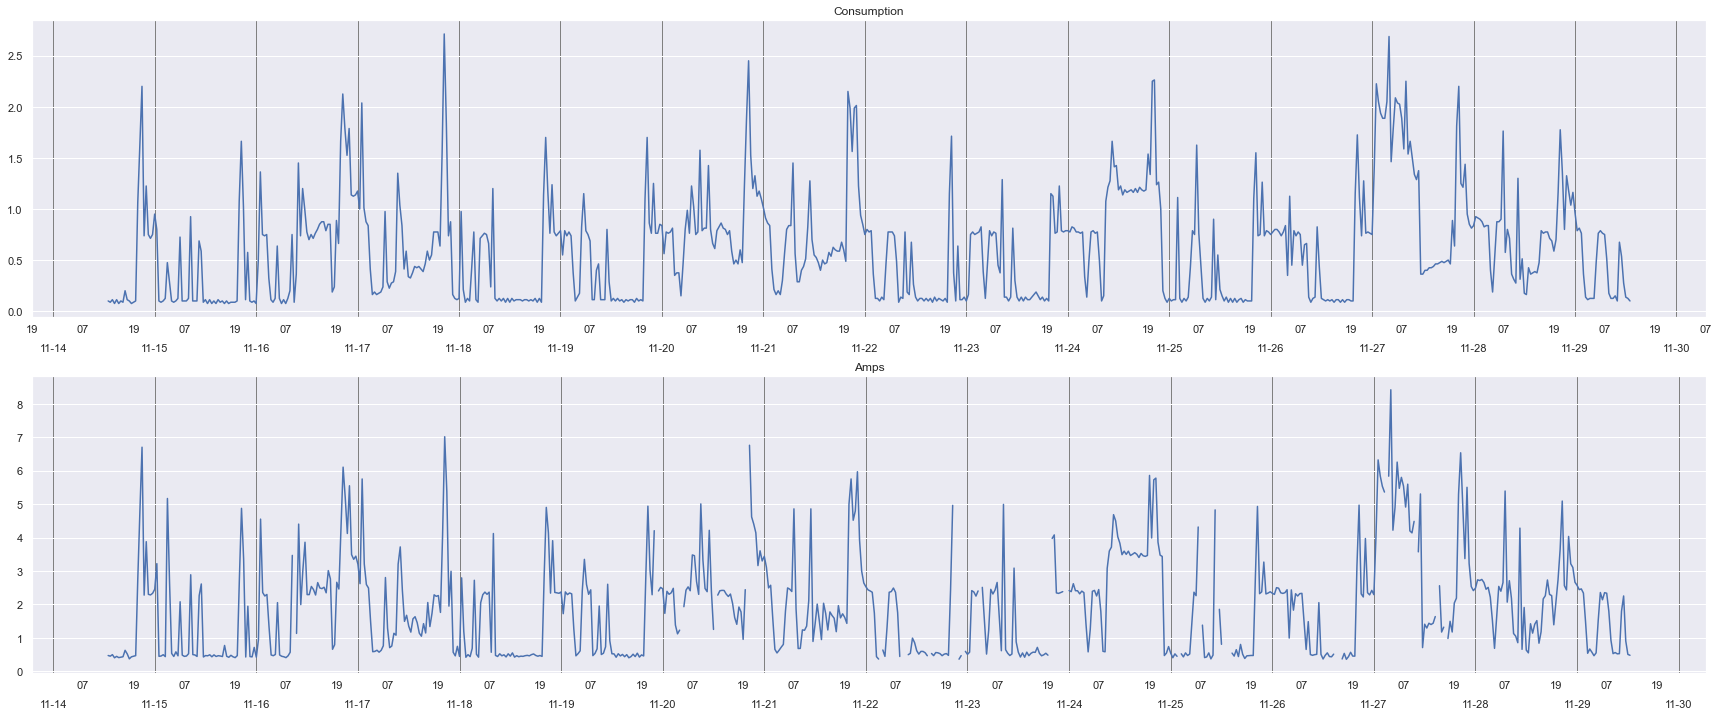

In [21]:
plot_consumption_amps(meters_with_ev[7])

    meter   make    model charger         drive_kms  has_ev
8  146262  Tesla  Model 3     Yes  15,000 to 20,000       1


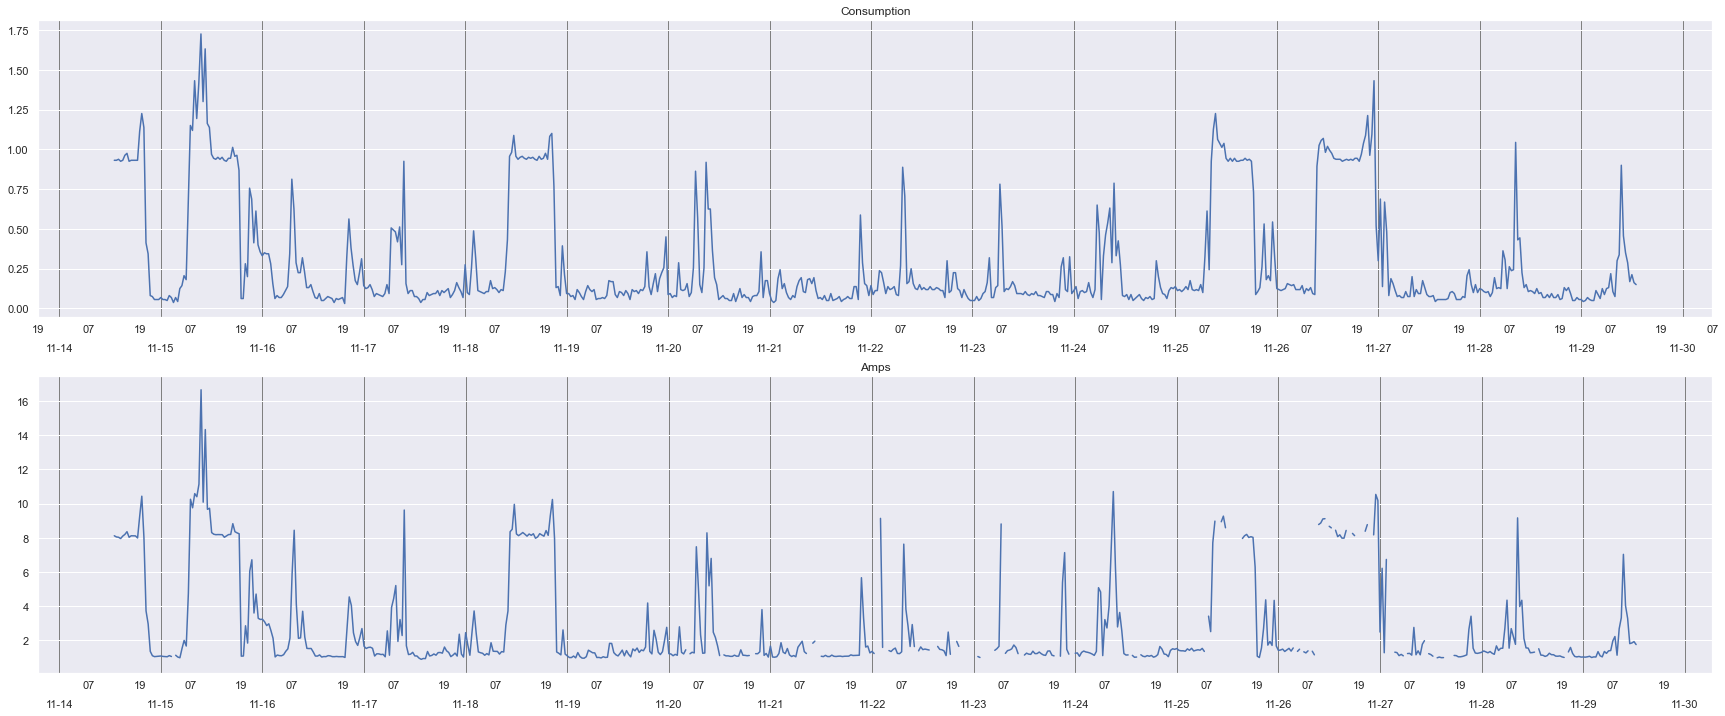

In [22]:
plot_consumption_amps(meters_with_ev[8])

    meter        make      model charger         drive_kms  has_ev
9  147369  Mitsubishi  Outlander      No  10,000 to 15,000       1


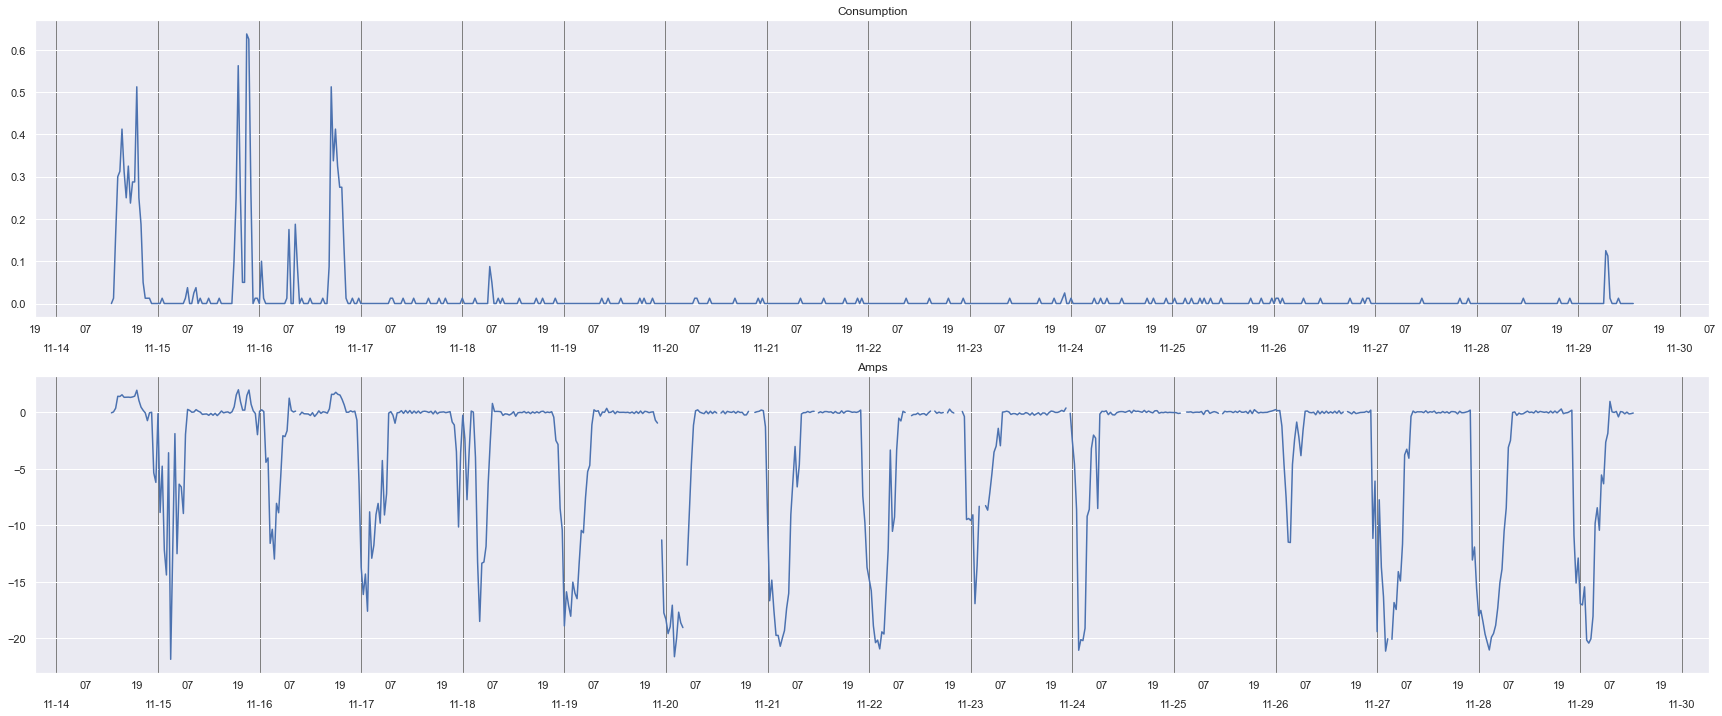

In [23]:
plot_consumption_amps(meters_with_ev[9])

     meter   make    model charger            drive_kms  has_ev
10  151074  tesla  Model 3      No  Greater than 20,000       1


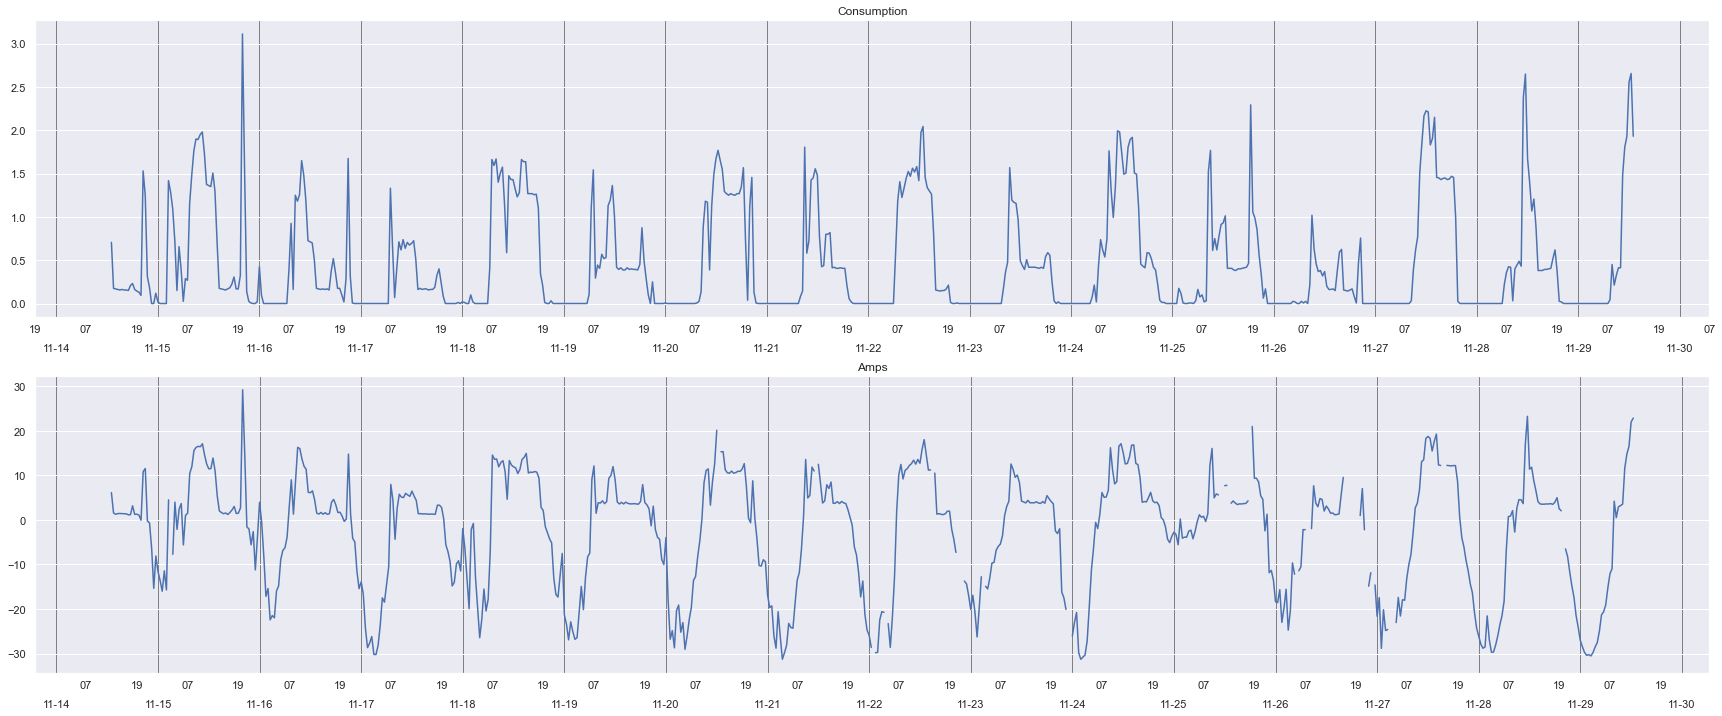

In [24]:
plot_consumption_amps(meters_with_ev[10])

     meter        make      model charger         drive_kms  has_ev
11  161806  Mitsubishi  Outlander     Yes  10,000 to 15,000       1


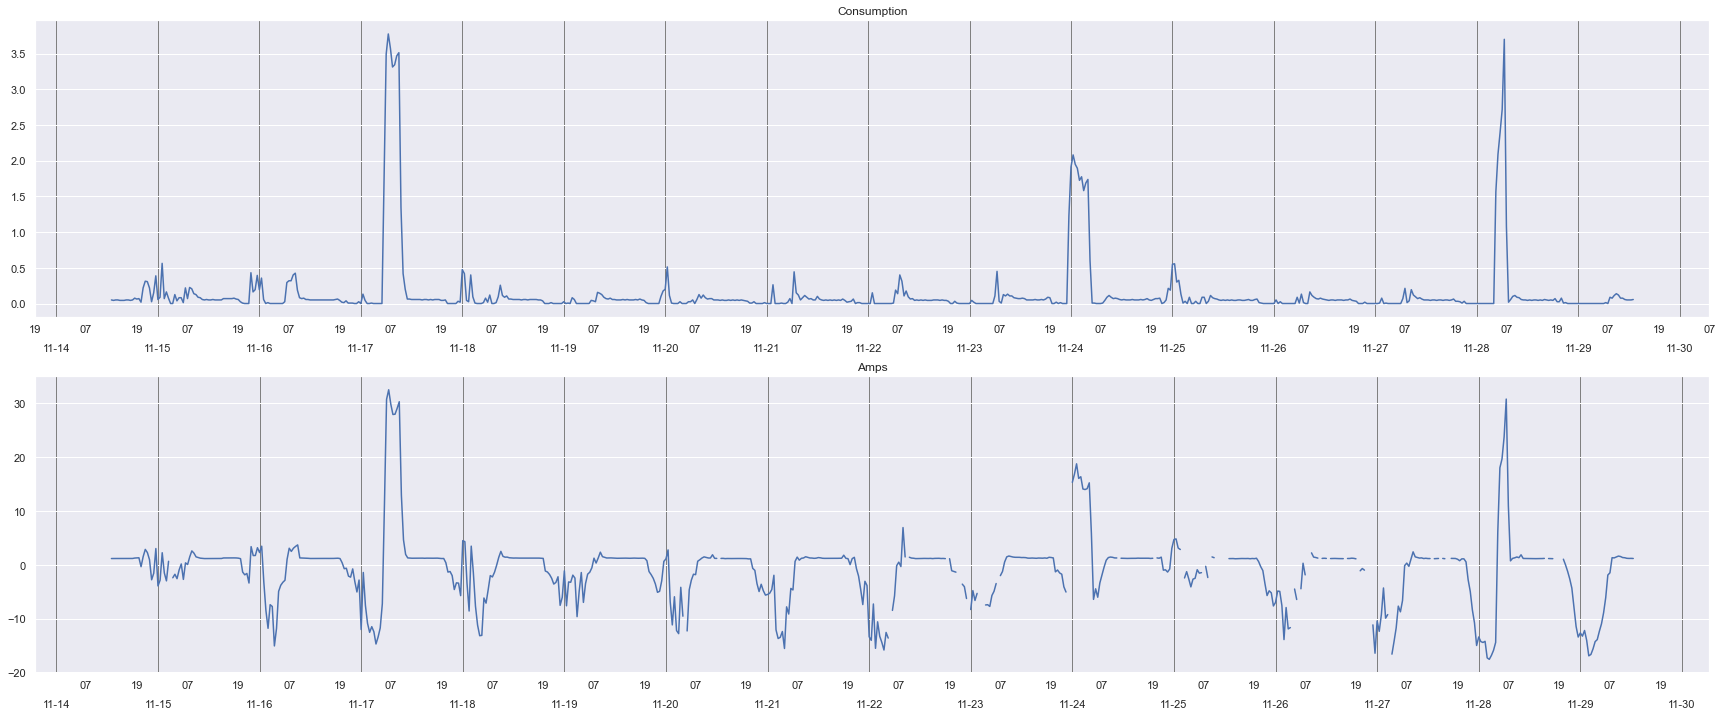

In [25]:
plot_consumption_amps(meters_with_ev[11])

     meter   make    model charger            drive_kms  has_ev
12  172232  Tesla  Model 3      No  Greater than 20,000       1


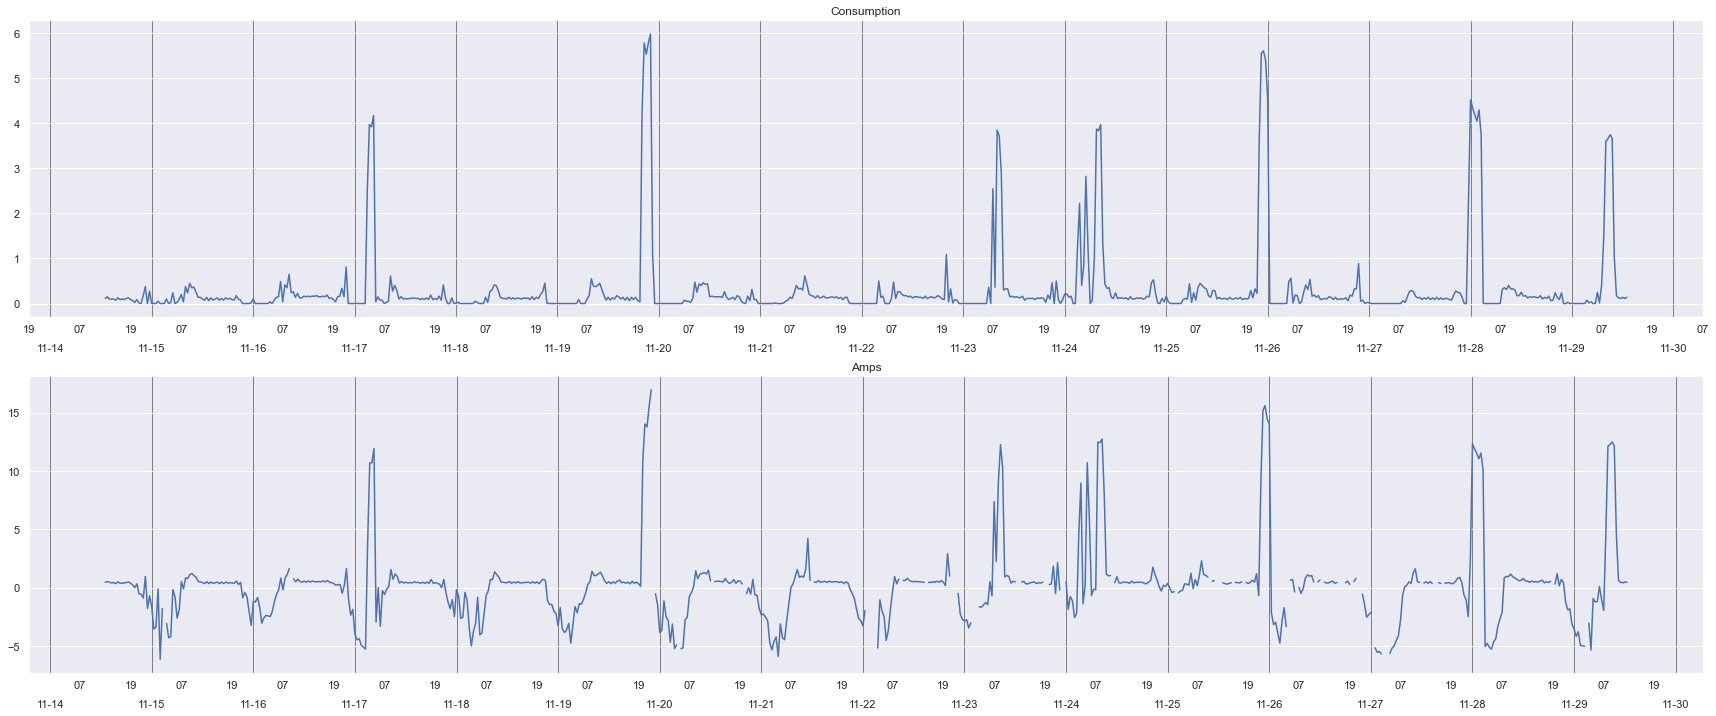

In [26]:
plot_consumption_amps(meters_with_ev[12])

     meter   make    model charger        drive_kms  has_ev
13  173927  Tesla  Model S     Yes  5,000 to 10,000       1


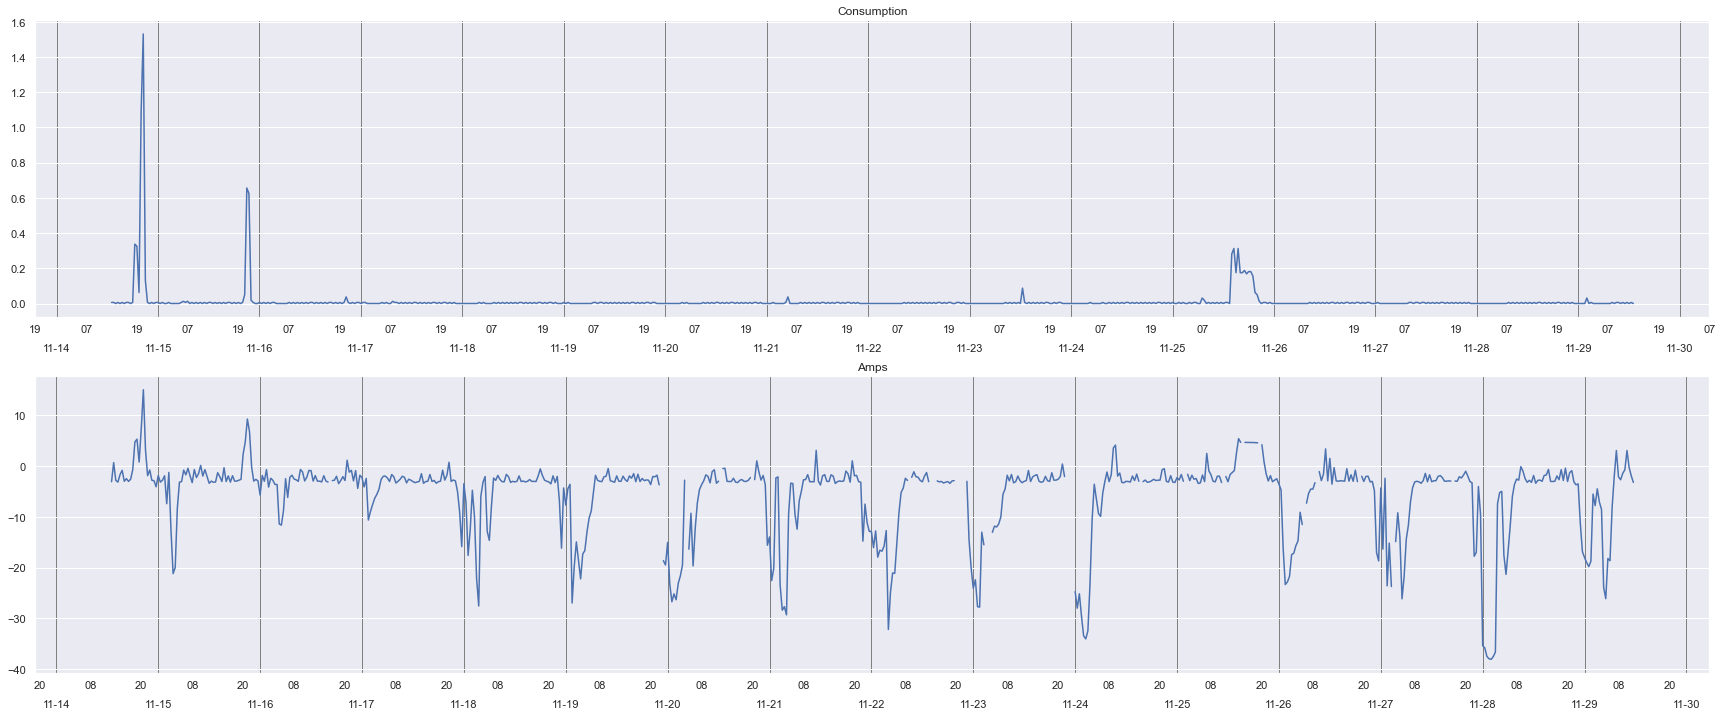

In [27]:
plot_consumption_amps(meters_with_ev[13])

     meter   make    model charger            drive_kms  has_ev
14  183009  Tesla  Model 3      No  Greater than 20,000       1


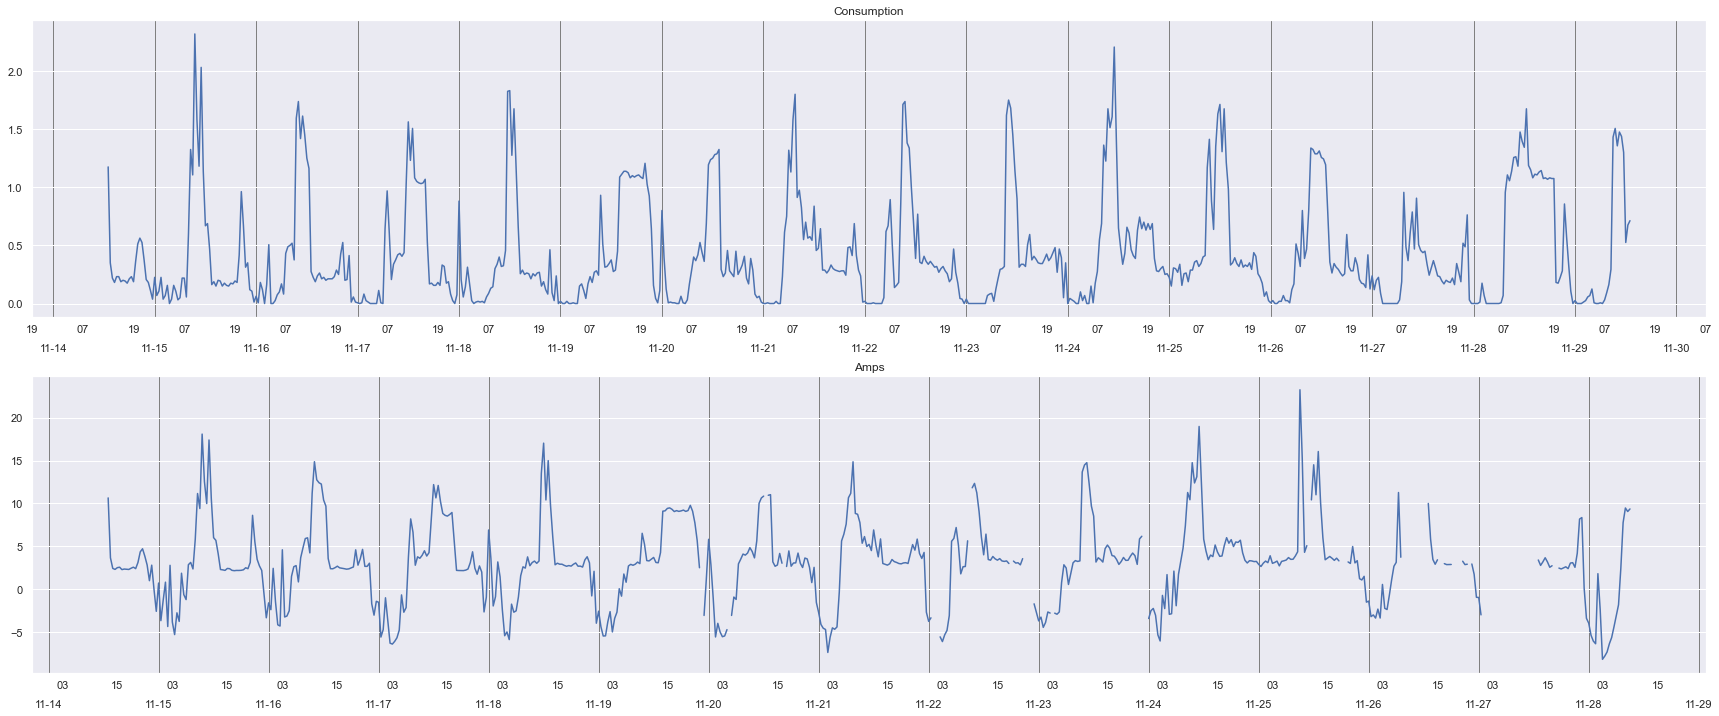

In [28]:
plot_consumption_amps(meters_with_ev[14])

     meter    make    model charger         drive_kms  has_ev
15  184799  Tesla   Model 3      No  10,000 to 15,000       1


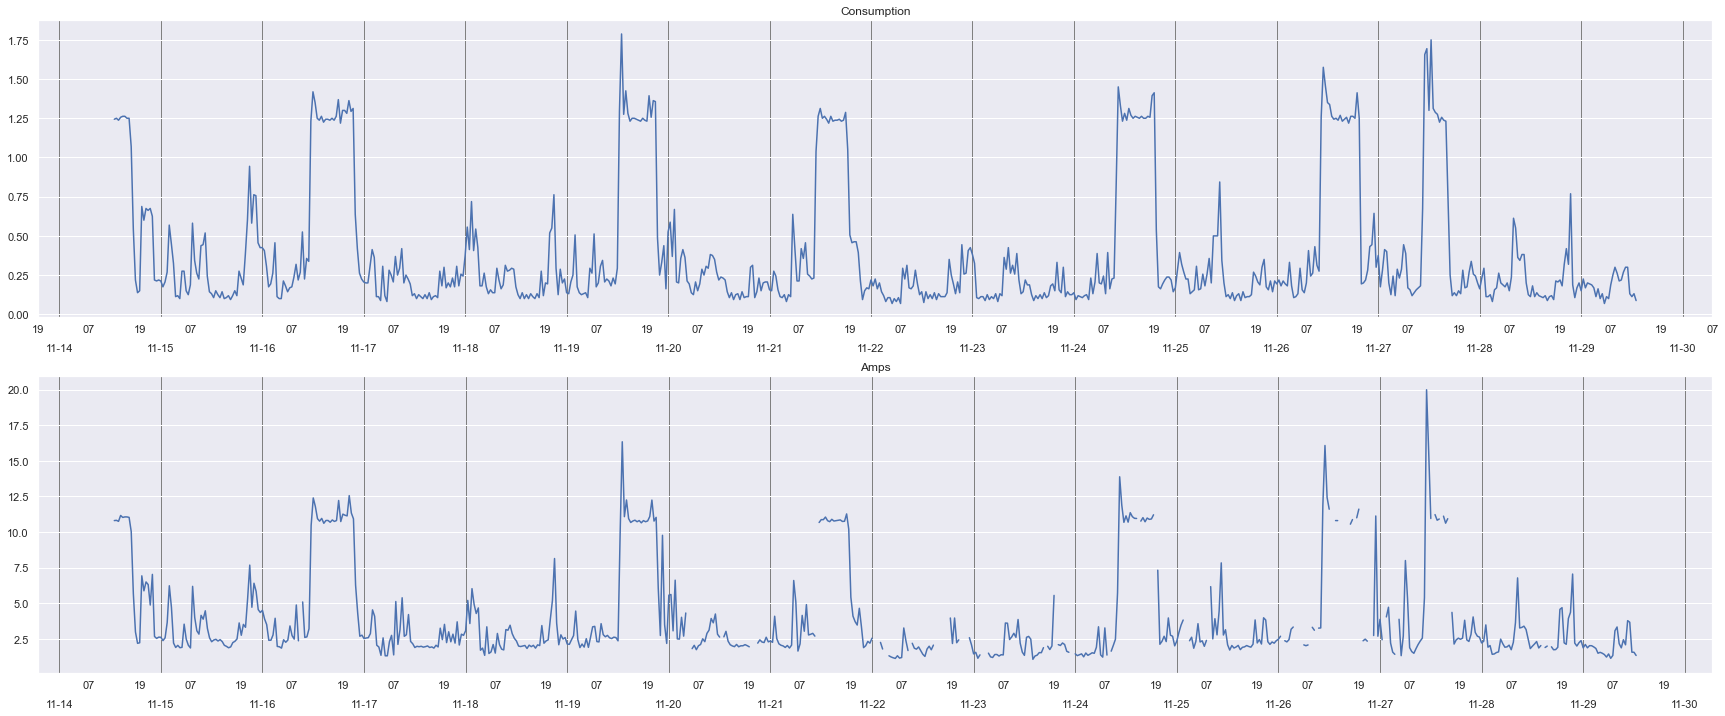

In [29]:
plot_consumption_amps(meters_with_ev[15])


<h3> No EV meters for same period as above </h3>

meter has no EV


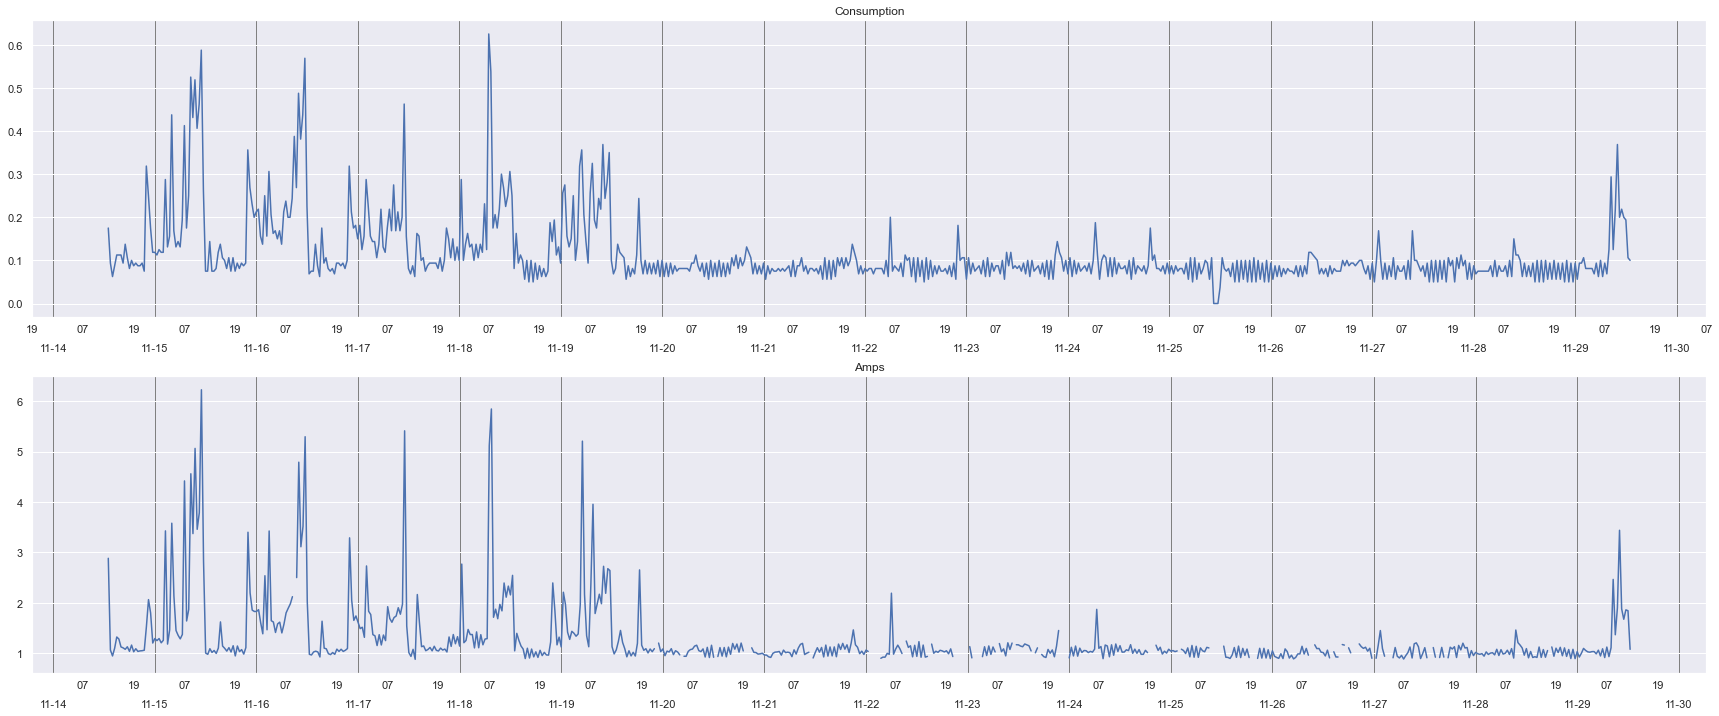

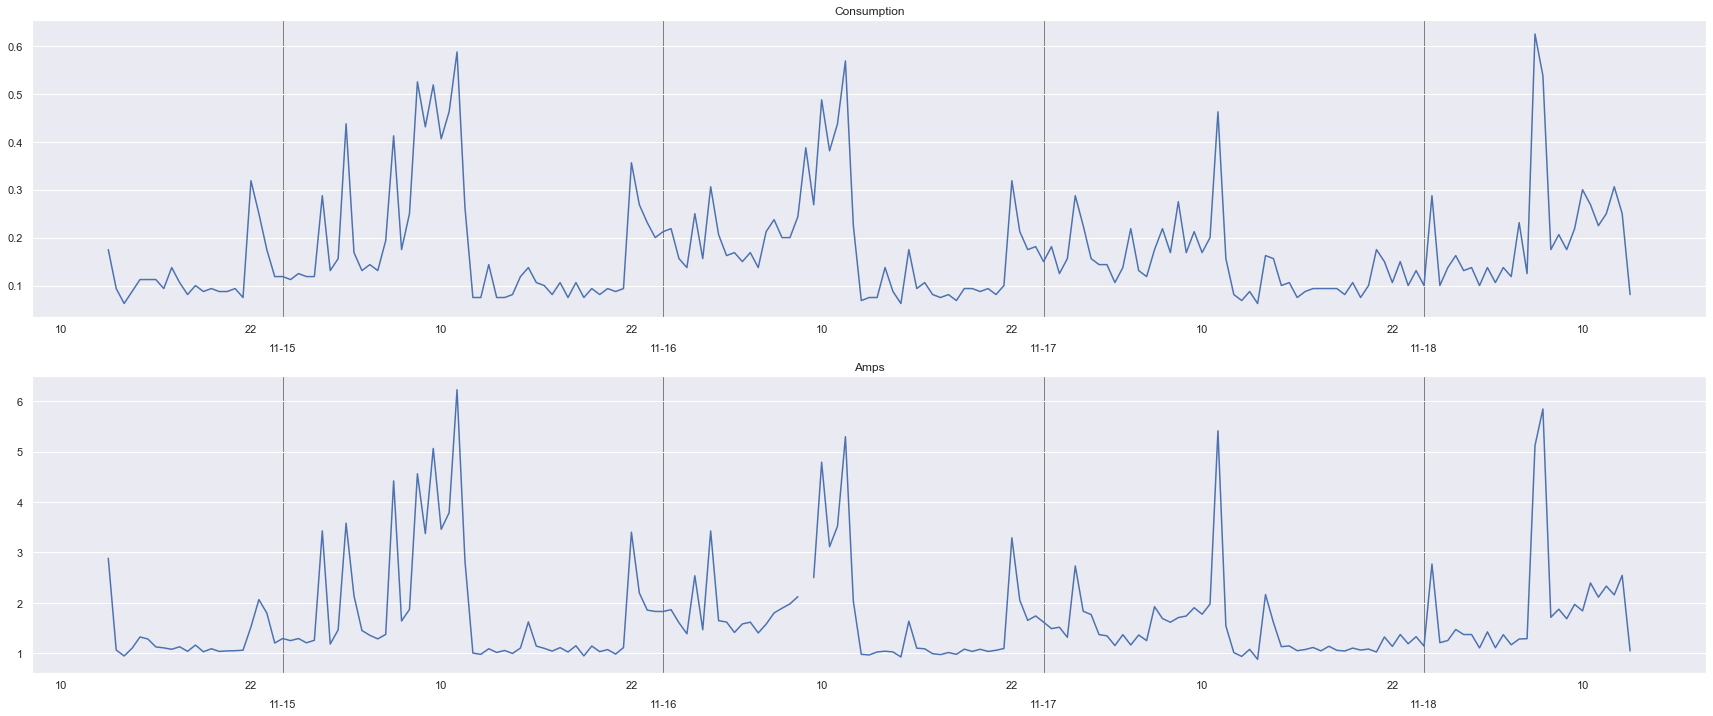

In [30]:
plot_consumption_amps(meters_with_no_ev[0])
plot_consumption_amps(meters_with_no_ev[0], start='2021-11-15', end='2021-11-19', verbose=False)

meter has no EV


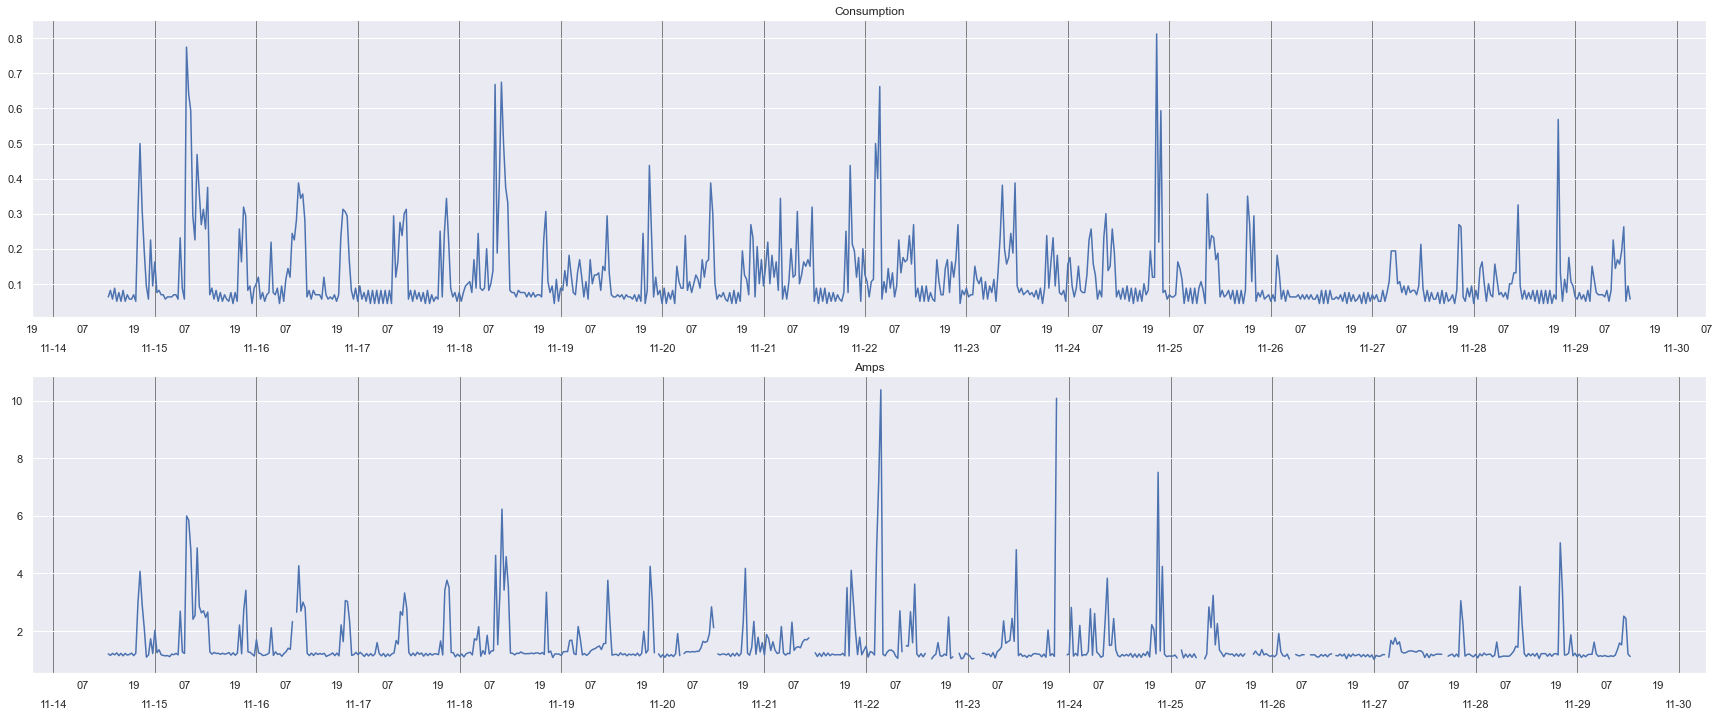

In [31]:
plot_consumption_amps(meters_with_no_ev[1])

meter has no EV


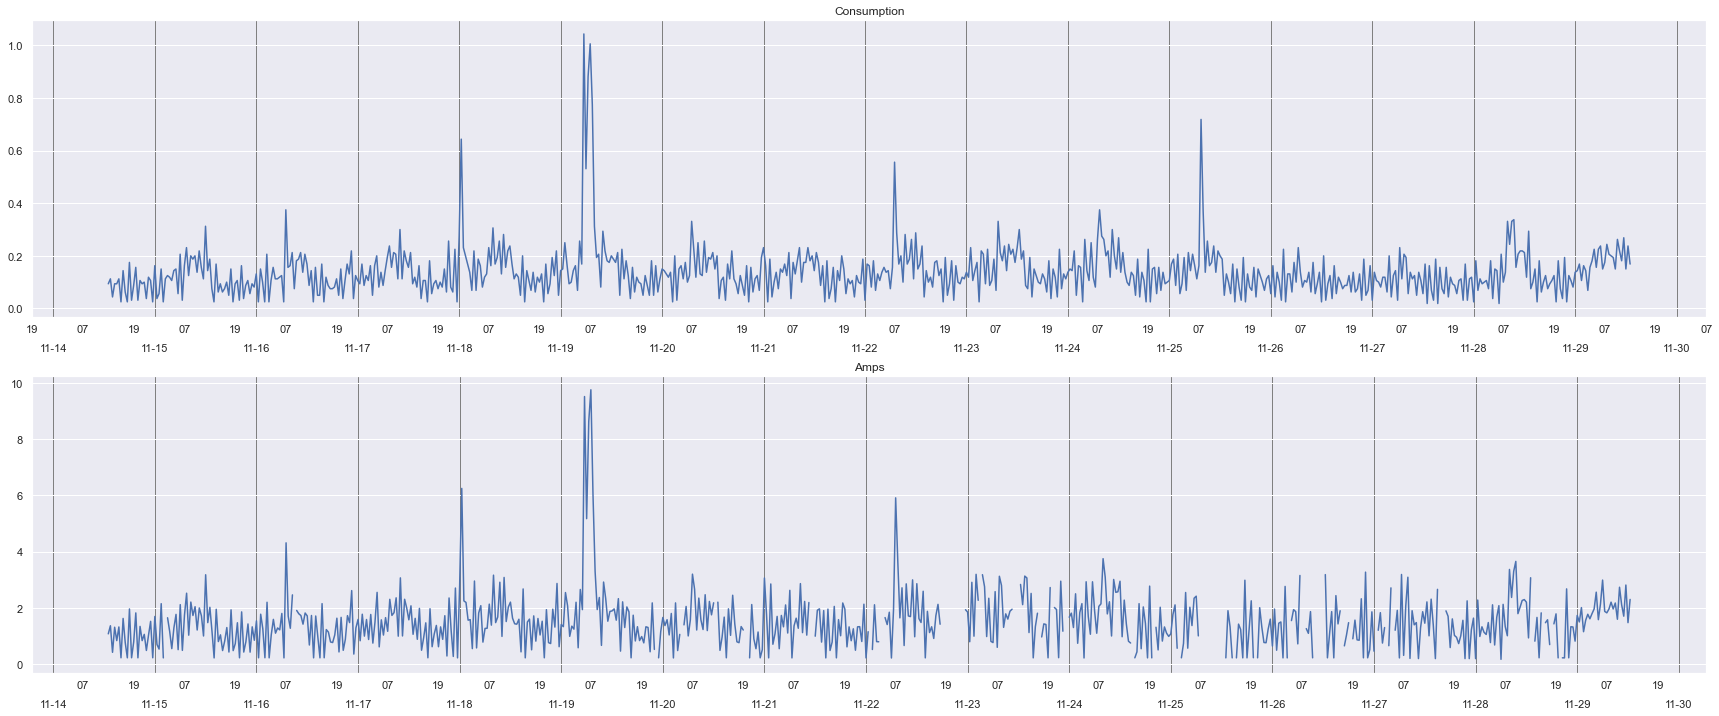

In [32]:
plot_consumption_amps(meters_with_no_ev[2])

meter has no EV


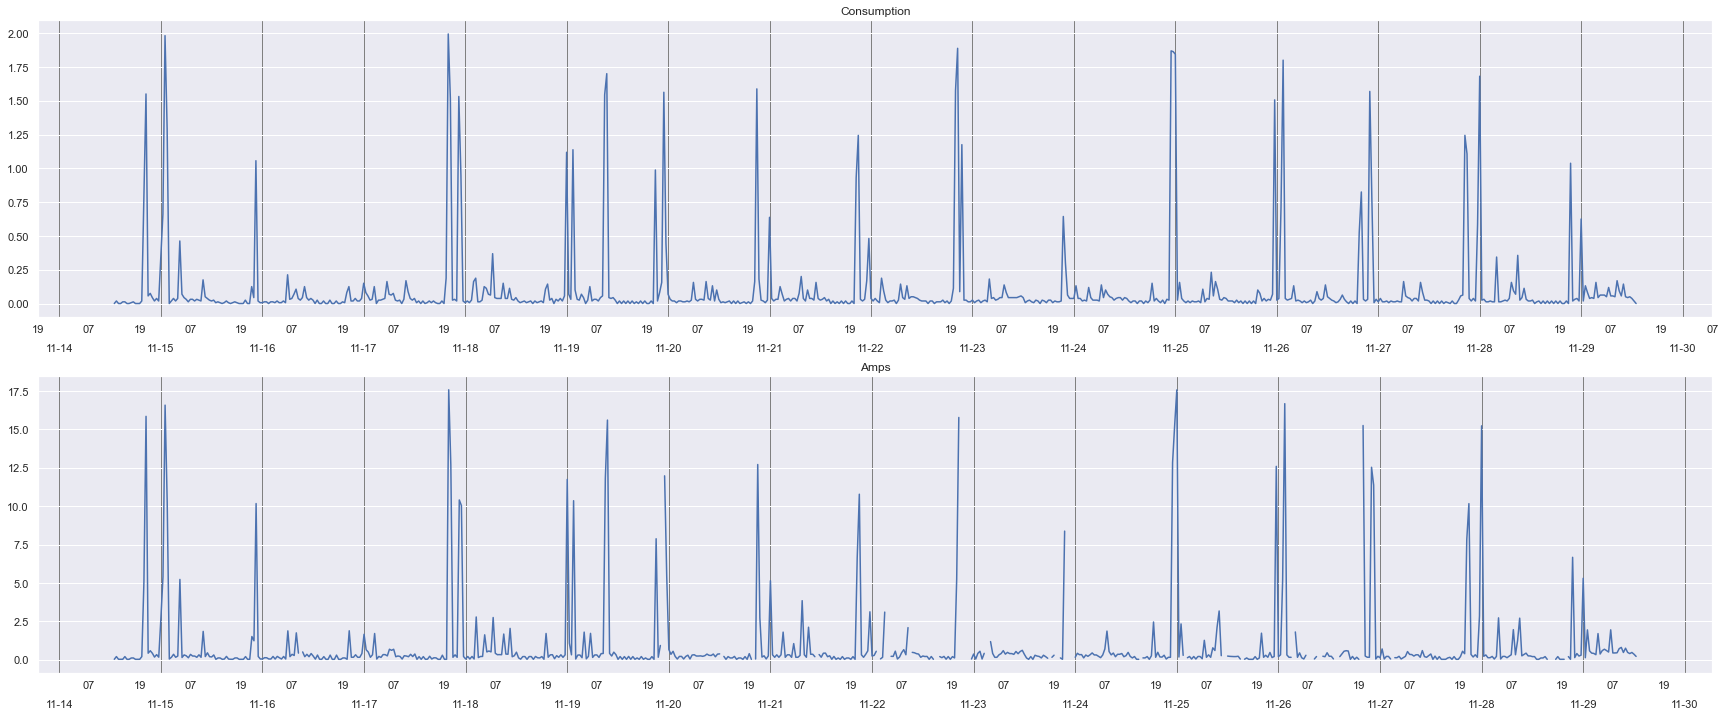

In [33]:
plot_consumption_amps(meters_with_no_ev[3])

meter has no EV


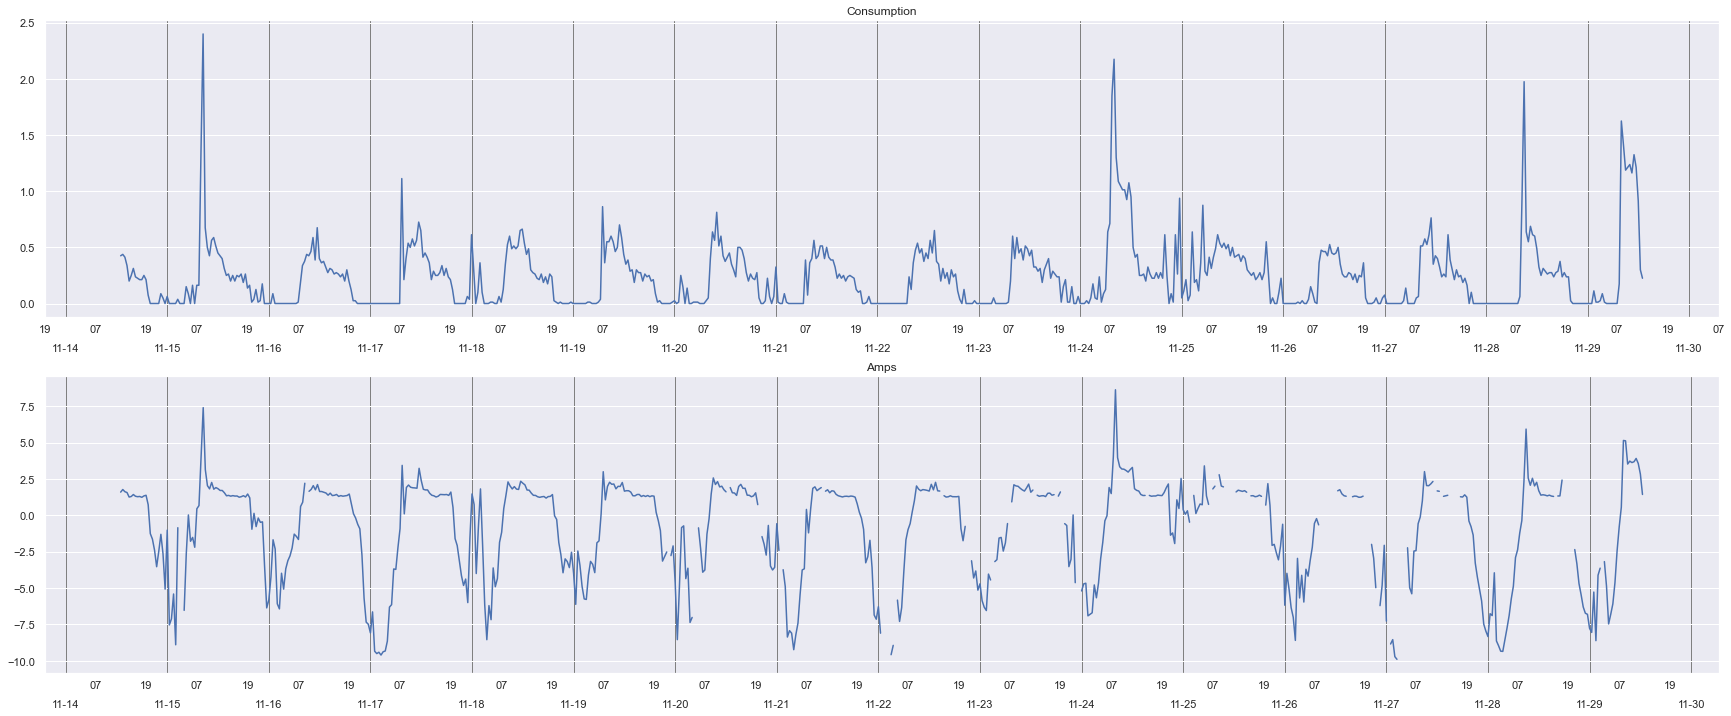

In [34]:
plot_consumption_amps(meters_with_no_ev[4])

meter has no EV


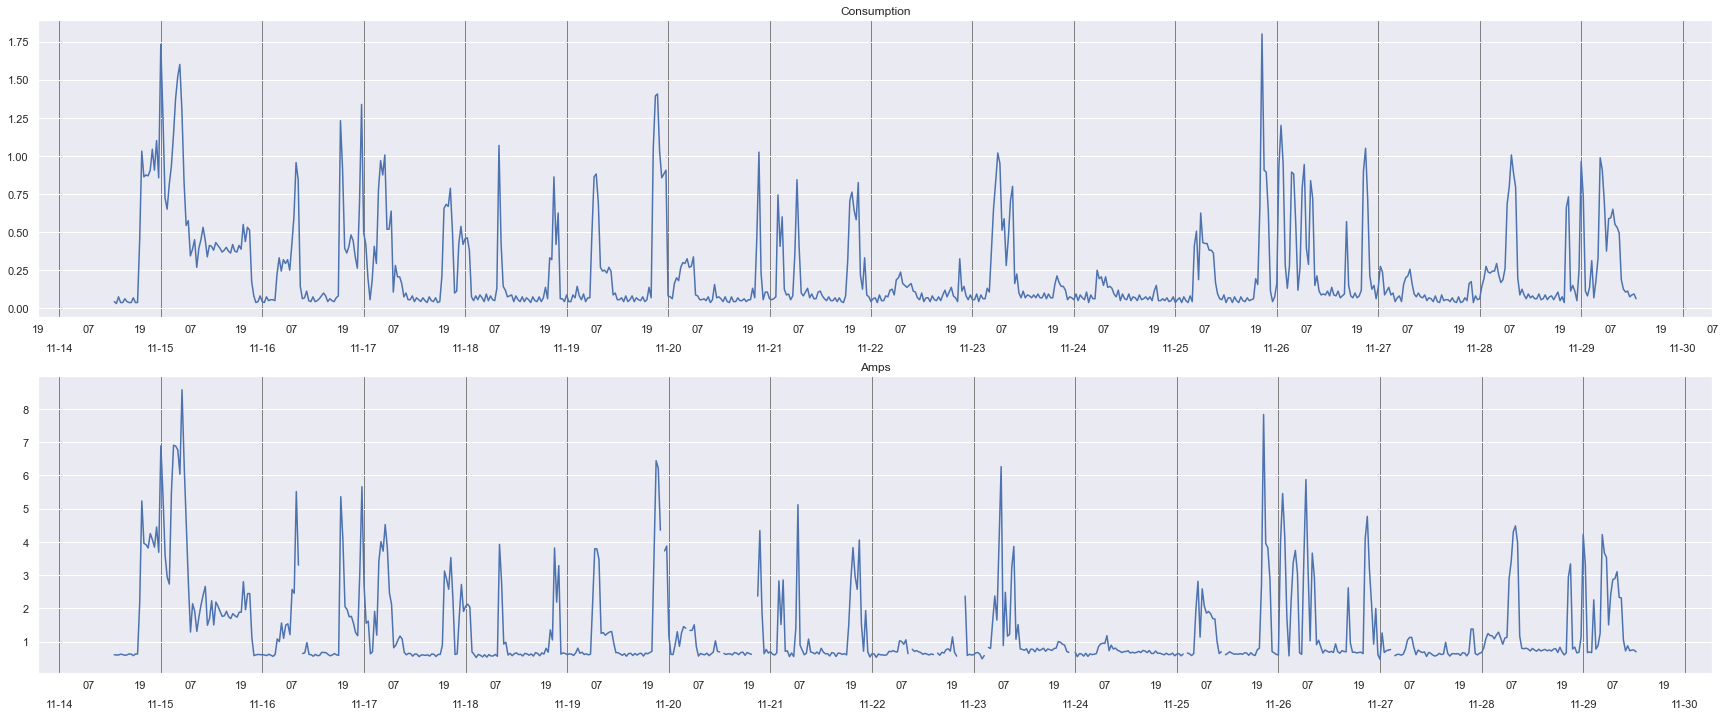

In [35]:
plot_consumption_amps(meters_with_no_ev[5])

meter has no EV


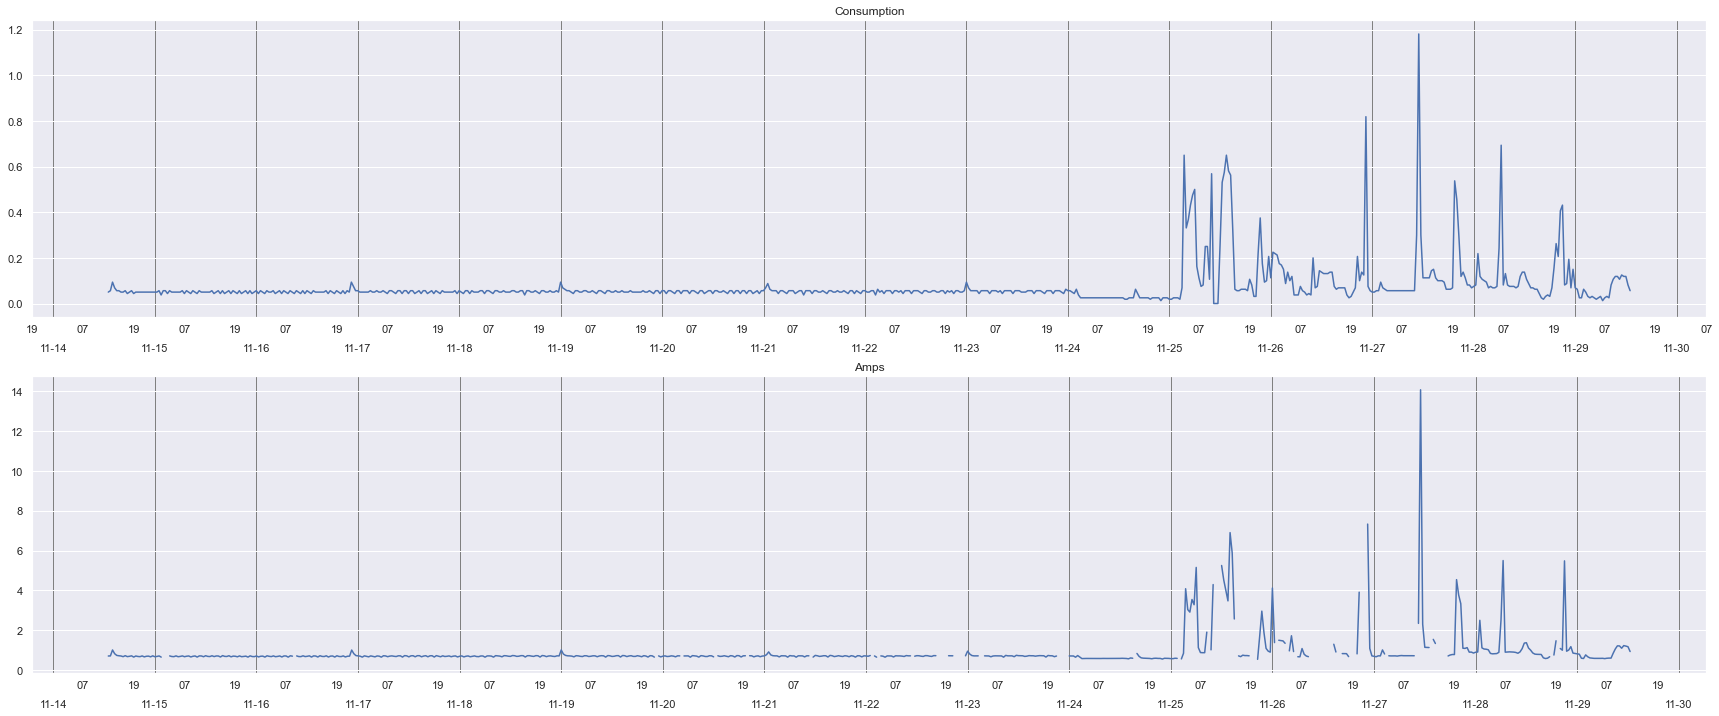

In [36]:

plot_consumption_amps(meters_with_no_ev[7])

meter has no EV


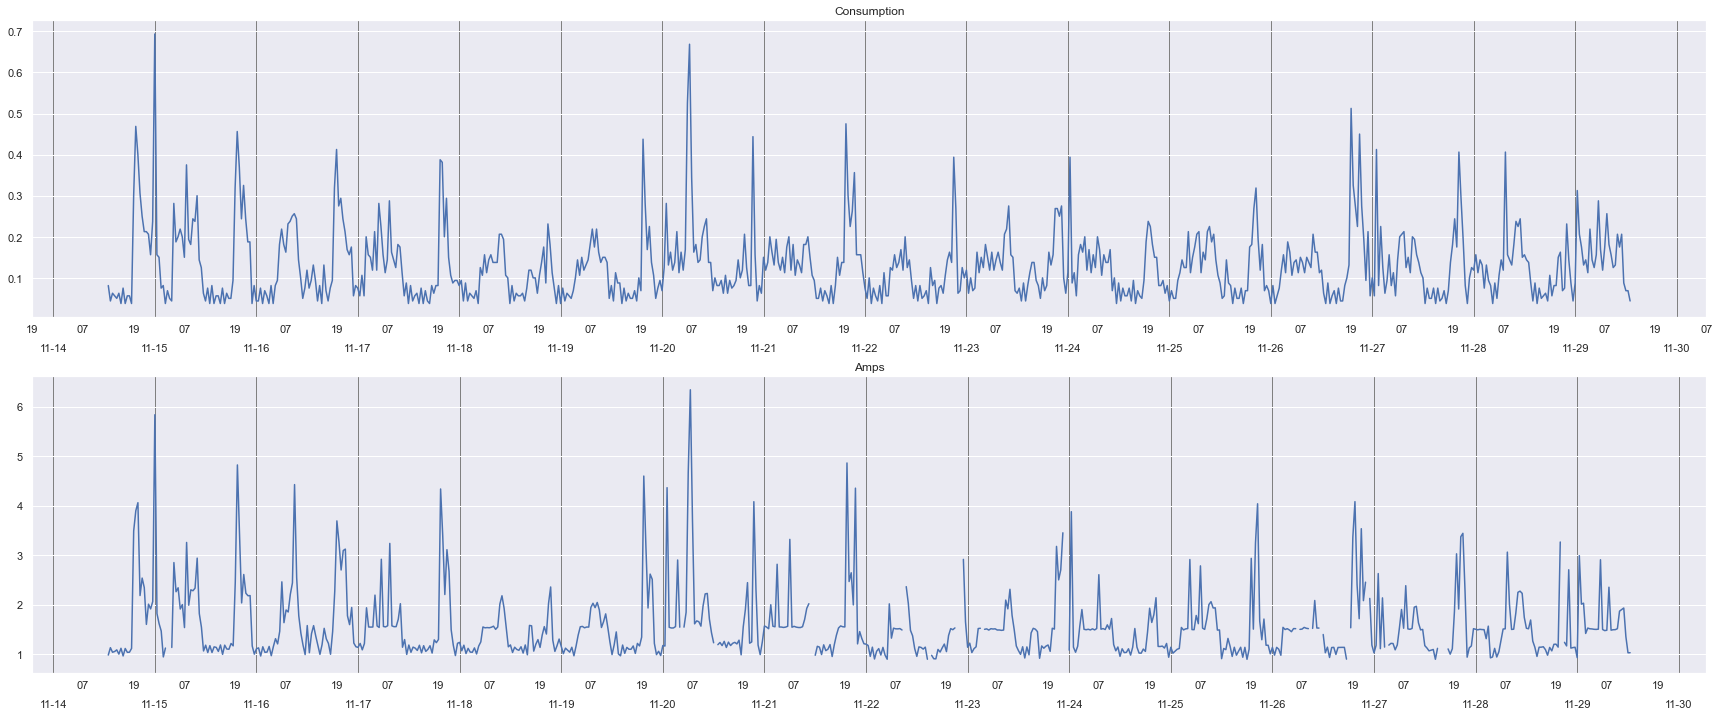

In [37]:
plot_consumption_amps(meters_with_no_ev[8])

meter has no EV


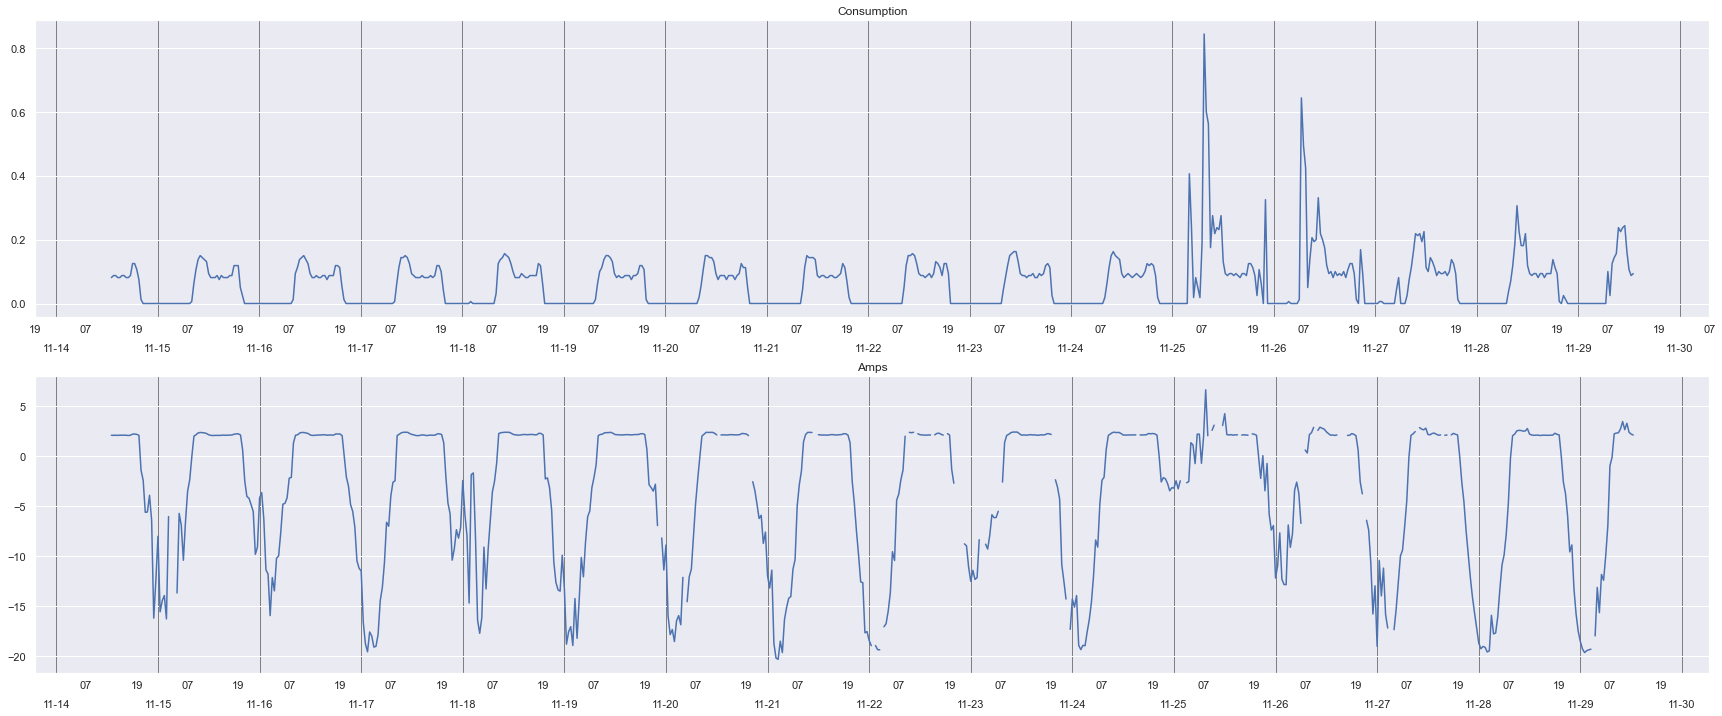

In [38]:
plot_consumption_amps(meters_with_no_ev[9])


meter has no EV


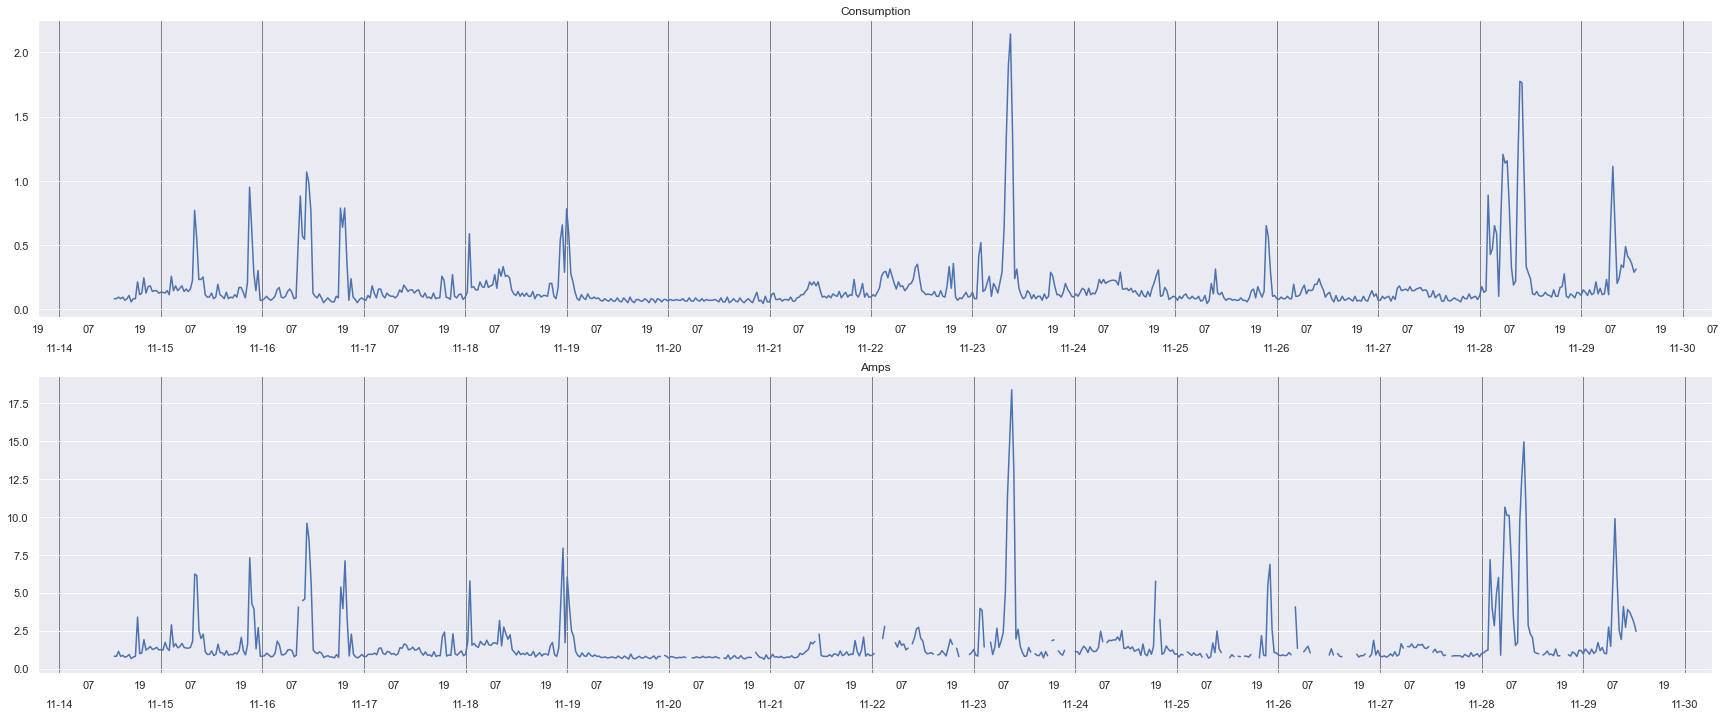

In [39]:
plot_consumption_amps(meters_with_no_ev[10])

meter has no EV


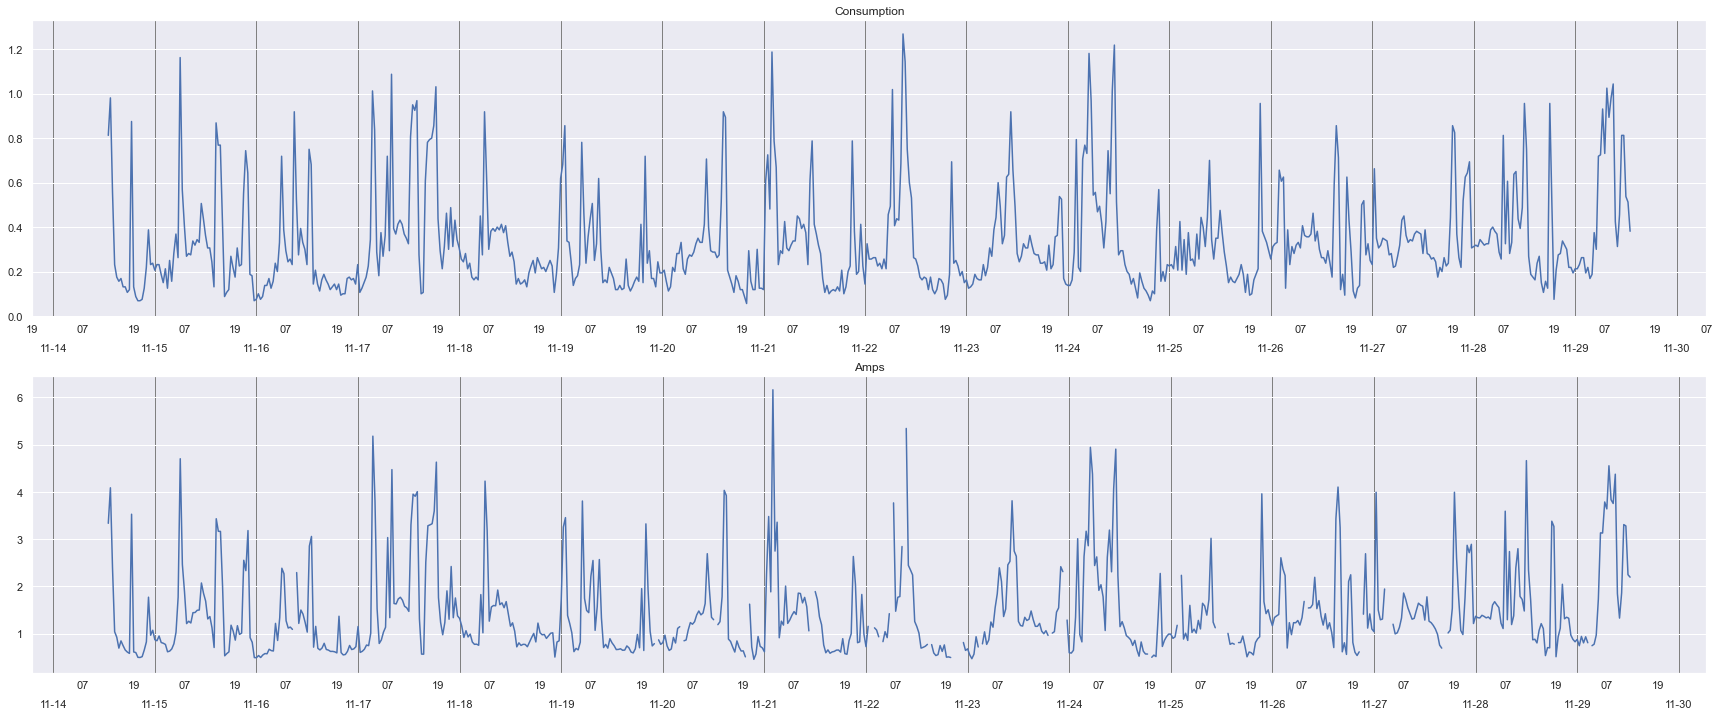

In [40]:
plot_consumption_amps(meters_with_no_ev[11])

meter has no EV


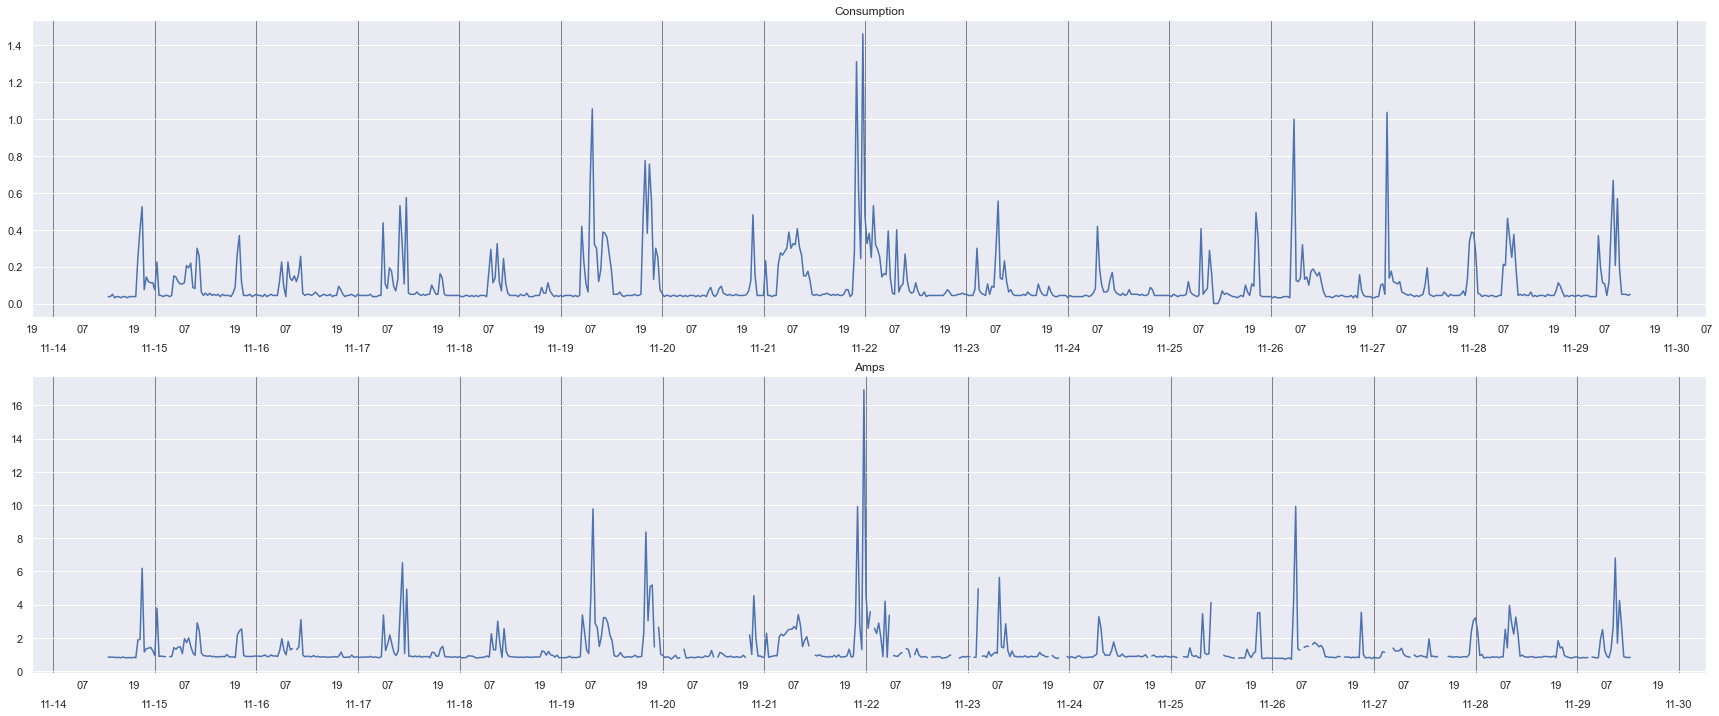

In [41]:
plot_consumption_amps(meters_with_no_ev[12])

meter has no EV
meter has no EV


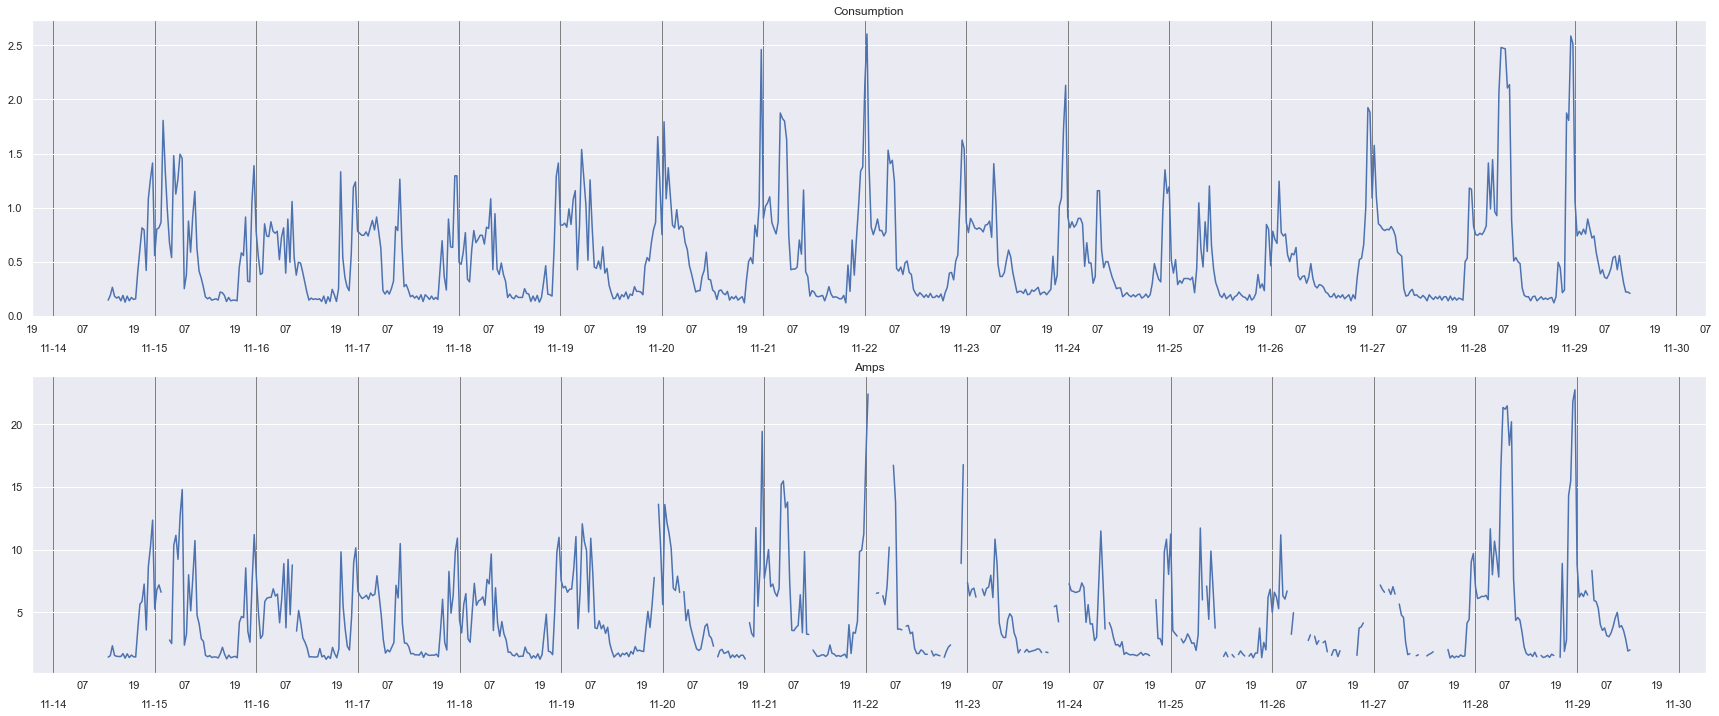

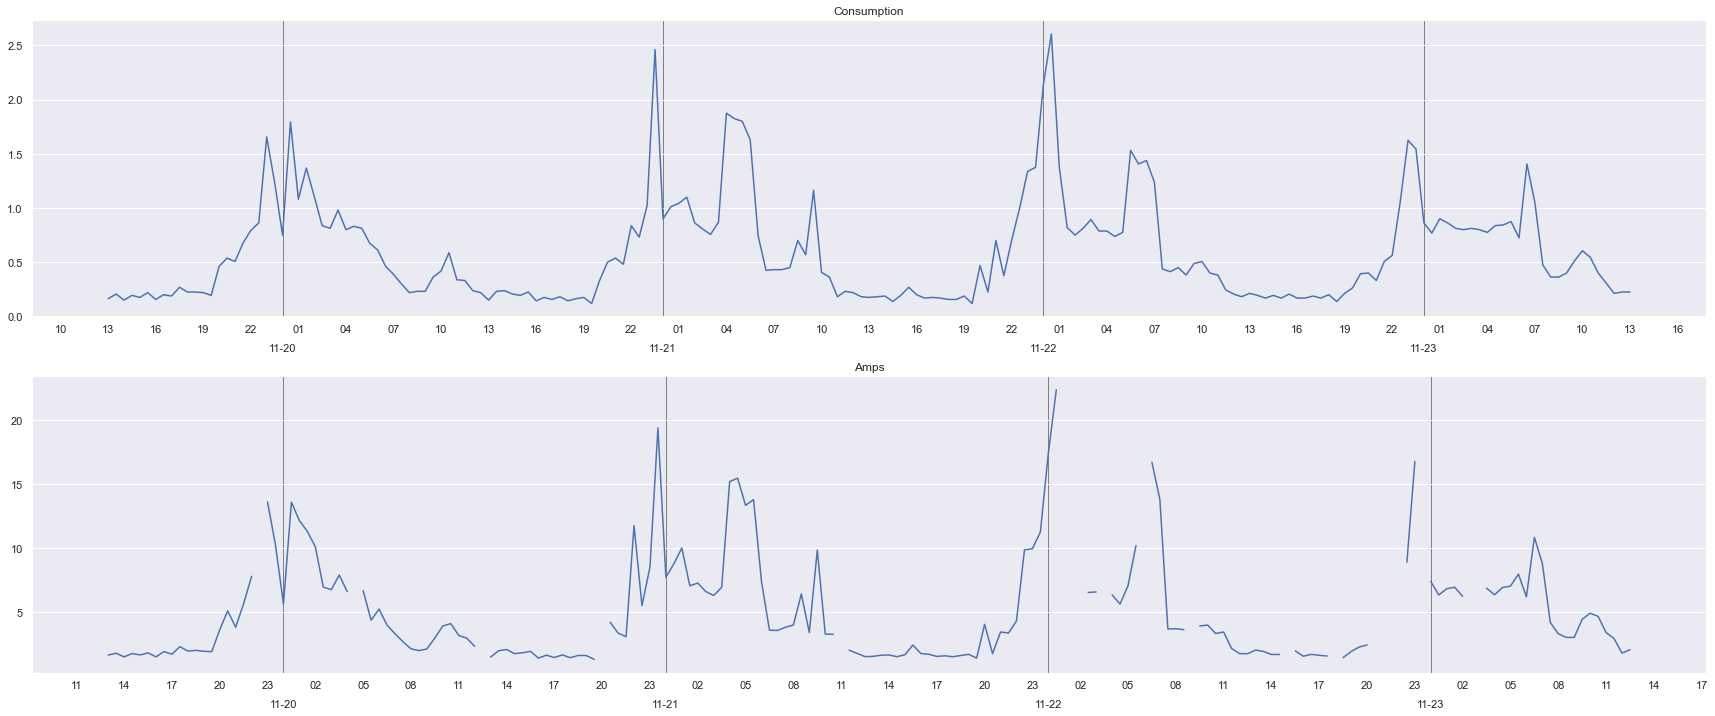

In [42]:
plot_consumption_amps(meters_with_no_ev[13])
plot_consumption_amps(meters_with_no_ev[13], start='2021-11-20', end='2021-11-24', hours_interval=3)

meter has no EV


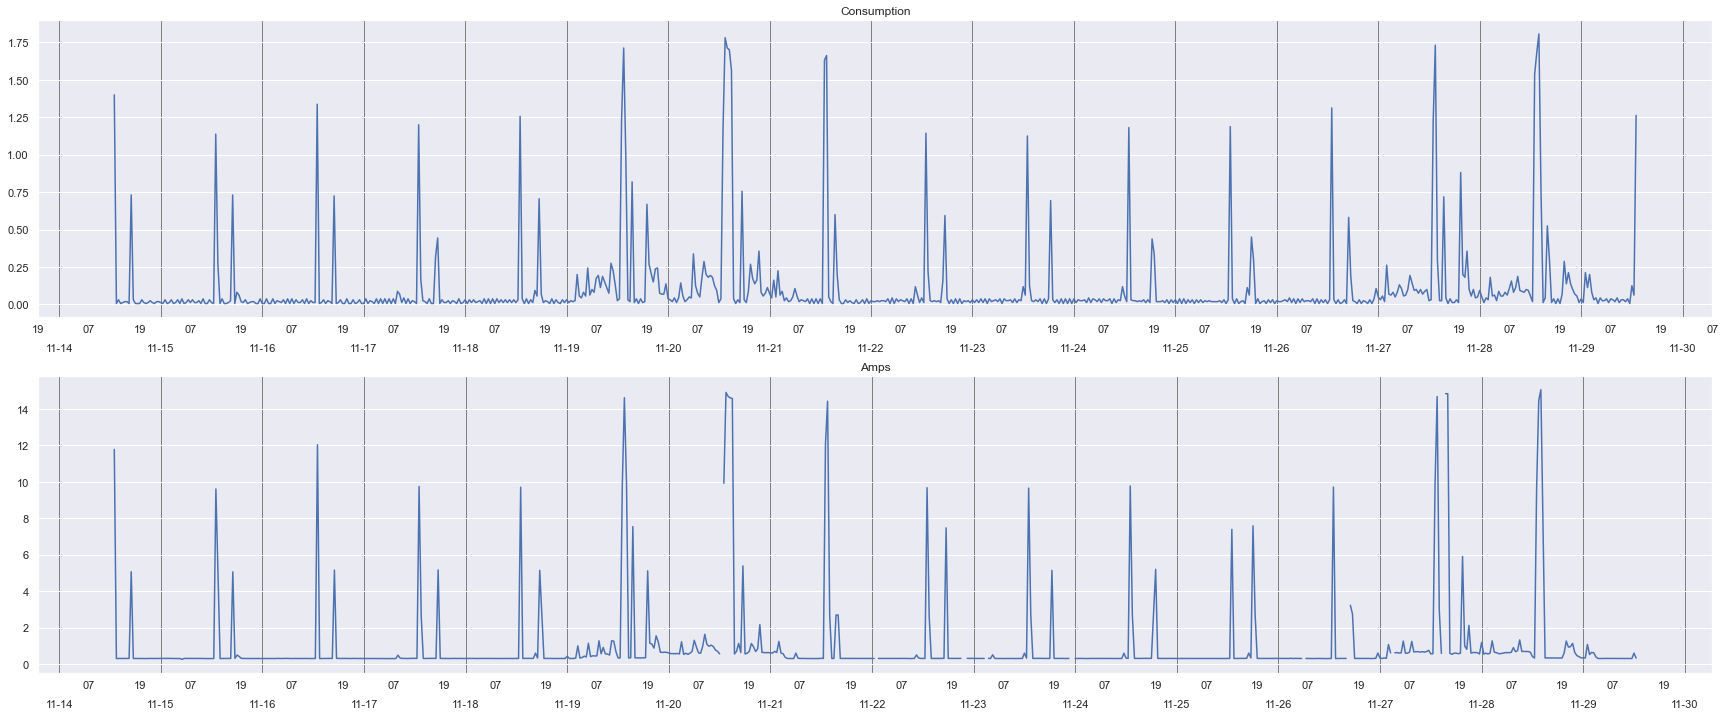

In [43]:
plot_consumption_amps(meters_with_no_ev[14])

meter has no EV


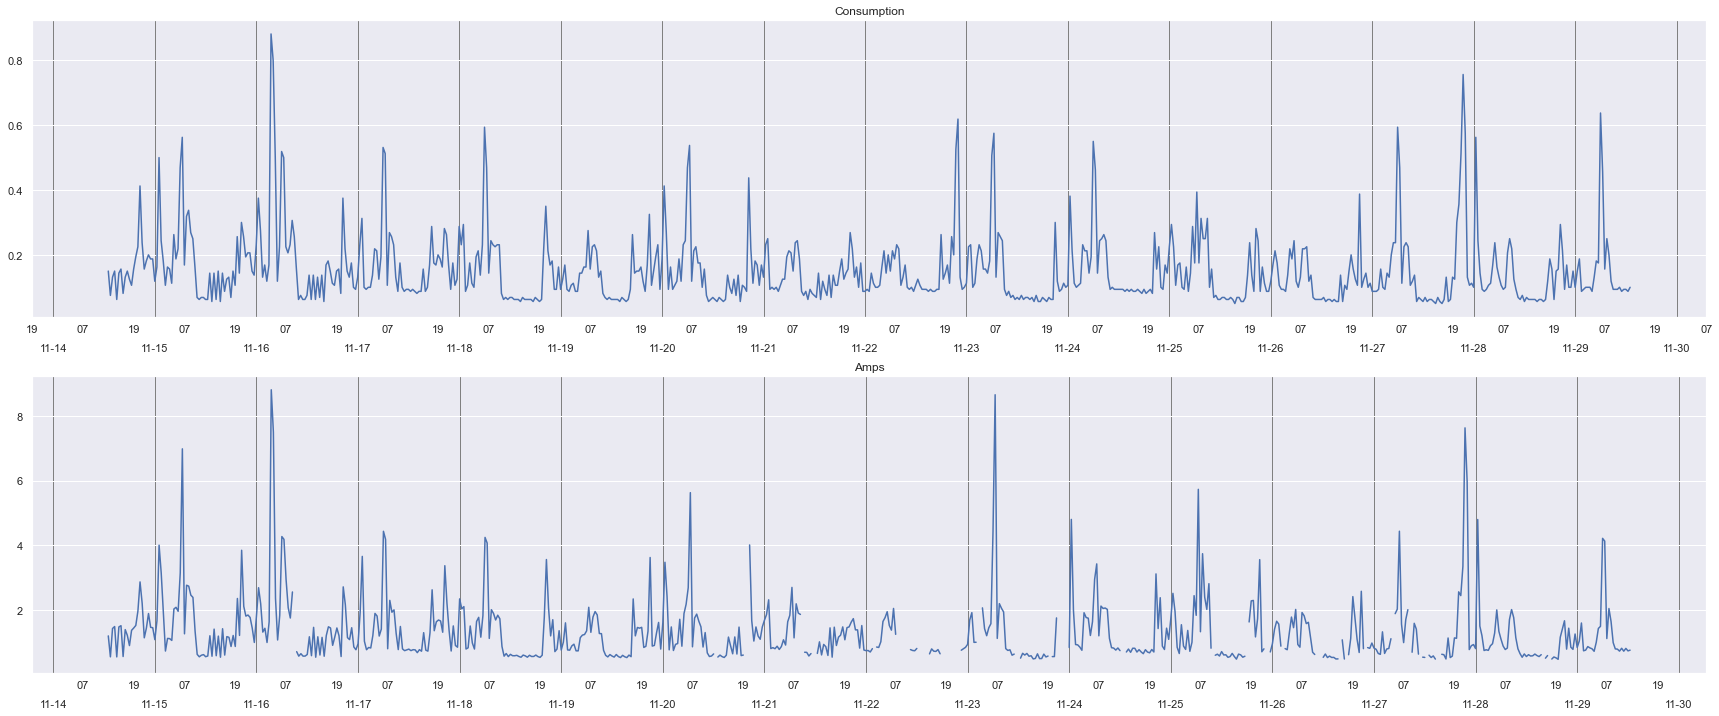

In [44]:
plot_consumption_amps(meters_with_no_ev[15])

<a id='Modelling'></a>

# Modelling

### old approach 

In [45]:
# df_consumption['has_ev'] = np.where(df_consumption['has_ev'].isna(), 0, 1)
# # for col in ['year', 'month', 'day', 'hour', 'minute']:
# #     df_consumption[col] = getattr(pd.DatetimeIndex(df_consumption['time']), col)
# df_consumption_analysis = df_consumption.drop(
#     columns=['generation', 'ev_make', 'ev_model', 'wallcharger', 'annual_km', 'annual_km_group',
#              'year', 'month', 'day', 'hour', 'minute'])
# df_consumption_analysis['identifier'] = df_consumption_analysis['meter'].astype('str') + df_consumption_analysis[
#     'element_uuid']
# df_consumption_analysis = df_consumption_analysis.drop(columns=['meter', 'element_uuid']).set_index(
#     ['identifier', 'time'])
# df_consumption_analysis.head()

In [46]:
# import statsmodels.api as sm
# from linearmodels import PanelOLS

# exog = sm.tools.add_constant(df_consumption_analysis['consumption'])
# endog = df_consumption_analysis['has_ev']
# # fixed effects model
# model_fe = PanelOLS(endog, exog, entity_effects=True)
# fe_res = model_fe.fit()
# print(fe_res)

In [47]:
# df_power_quality['has_ev'] = np.where(df_power_quality['has_ev'].isna(), 0, 1)
# # for col in ['year', 'month', 'day', 'hour', 'minute']:
# #     df_power_quality[col] = getattr(pd.DatetimeIndex(df_power_quality['time']), col)
# df_power_quality.drop(
#     columns=['overground_or_underground', 'ev_make', 'ev_model', 'wallcharger', 'annual_km', 'annual_km_group'],
#     inplace=True)
# df_power_quality['identifier'] = df_power_quality['meter'].astype('str') + df_power_quality['channel_cd']
# df_power_quality.drop(columns=['meter', 'channel_cs'], inpalce=True)
# df_power_quality.set_index(['identifier', 'time'], inplace=True)
# df_power_quality.head()

In [48]:
# import statsmodels.api as sm
# from linearmodels import PanelOLS

# exog = sm.tools.add_constant(df_power_quality['amps'])
# exog = sm.tools.add_constant(df_power_quality['voltage_lvt'])
# exog = sm.tools.add_constant(df_power_quality['power_factor_pf'])
# exog = sm.tools.add_constant(df_power_quality['number_of_phases'])
# endog = df_consumption_analysis['has_ev']
# # fixed effects model
# model_fe = PanelOLS(endog, exog, entity_effects=True)
# fe_res = model_fe.fit()
# print(fe_res)

## Approach one

- Collapsing channels in power quality<br> 
    phase 1: drop channel b<br>
    phase 3: collapse channels; voltage -> mean, amps -> mean, power factor -> absolute mean<br>
- Convert power quality data to 30 minutes data points
- keeping only 30m measurements in power quality
- Collapsing variables to be weekly averages (as features)<br>
- Logistic regression<br>

(note: element_uuid is dropped from consumption)

In [49]:
df_power_quality_for_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21305408 entries, 0 to 21305407
Data columns (total 29 columns):
 #   Column            Dtype                                        
---  ------            -----                                        
 0   meter             int64                                        
 1   time              datetime64[ns, tzfile('Australia/Melbourne')]
 2   voltage           float64                                      
 3   amps              float64                                      
 4   abs_power_factor  float64                                      
 5   phases            float64                                      
 6   infrast           category                                     
 7   dayofyear         int64                                        
 8   weekofyear        int64                                        
 9   dayofweek         int64                                        
 10  day               int64                             

In [50]:
df_consumption_app01 = df_consumption_for_features.copy().set_index(['meter', 'time'])[['consumption', 'generation', 'total_consumption', 'cons_above_75', 'cons_above_80', 'cons_above_85']]
df_consumption_app01.info()
display('df_consumption_app01.describe().T', f'df_consumption_app01.head()')

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 21773779 entries, (396, Timestamp('2020-10-01 10:00:00+1000', tz='dateutil/Australia/Melbourne')) to (792189, Timestamp('2021-12-01 10:30:00+1100', tz='dateutil/Australia/Melbourne'))
Data columns (total 6 columns):
 #   Column             Dtype  
---  ------             -----  
 0   consumption        float64
 1   generation         float64
 2   total_consumption  float64
 3   cons_above_75      int32  
 4   cons_above_80      int32  
 5   cons_above_85      int32  
dtypes: float64(3), int32(3)
memory usage: 831.3 MB


df_consumption_app01.describe().T
                     count    mean     std  min     25%     50%     75%  \
consumption       21773779 0.22414 0.39891    0 0.03750 0.09370 0.23120   
generation        21773779 0.02844 0.19277    0       0       0       0   
total_consumption 21773779 0.25257 0.42948    0 0.04370 0.10000 0.26870   
cons_above_75     21773779 0.24810 0.43191    0       0       0       0   
cons_above_80     21773779 0.19712 0.39783    0       0       0       0   
cons_above_85     21773779 0.14858 0.35567    0       0       0       0   

                       max  
consumption       15.95000  
generation         8.47500  
total_consumption 15.95000  
cons_above_75            1  
cons_above_80            1  
cons_above_85            1  

df_consumption_app01.head()
                                 consumption  generation  total_consumption  \
meter time                                                                    
396   2020-10-01 10:00:00+10:00      0.11870           0            0.11870   
      2020-10-01 10:30:00+10:00      0.11870           0            0.11870   
      2020-10-01 11:00:00+10:00      0.08120           0            0.08120   
      2020-10-01 11:30:00+10:00      0.09370           0            0.09370   
      2020-10-01 12:00:00+10:00      0.10000           0            0.10000   

                                 cons_above_75  cons_above_80  cons_above_85  
meter time                                                                    
396   2020-10-01 10:00:00+10:00              0              0              0  
      2020-10-01 10:30:00+10:00              0              0              0  
      2020-10-01 11:00:00+10:00              0              0              0  
      2020-10-01 11:30:00+10:00              0              0              0  
      2020-10-01 12:00:00+10:00              0              0              0

In [51]:
df_power_quality_app01 = df_power_quality_for_features.copy().set_index(['meter', 'time'])
df_power_quality_app01 = df_power_quality_app01[
    ['voltage', 'amps', 'abs_power_factor', 'phases',
     'weekofyear', 'weekend', 'amps_above_75', 'amps_above_80', 'amps_above_85', 'has_ev']
    ]
# df_power_quality_app01 = df_power_quality_app01.query("phases == 3 | channel == 'a'")\
#     .groupby(['meter', 'time'])\
#         .aggregate({
#             'amps': 'sum',
#             'voltage': 'mean',
#             'abs_power_factor': 'mean',
#             'phases': 'first',
#             'has_ev': 'first',
#             'weekofyear': 'first',
#             'weekend': 'first',
#             'amps_above_80': 'first'
#         })
df_power_quality_app01.info()
display('df_power_quality_app01.describe().T', f'df_power_quality_app01.head()')


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 21305408 entries, (396, Timestamp('2020-10-01 00:00:00+1000', tz='dateutil/Australia/Melbourne')) to (792189, Timestamp('2021-11-29 23:30:00+1100', tz='dateutil/Australia/Melbourne'))
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   voltage           float64
 1   amps              float64
 2   abs_power_factor  float64
 3   phases            float64
 4   weekofyear        int64  
 5   weekend           int32  
 6   amps_above_75     int32  
 7   amps_above_80     int32  
 8   amps_above_85     int32  
 9   has_ev            int32  
dtypes: float64(4), int32(5), int64(1)
memory usage: 1.3 GB


df_power_quality_app01.describe().T
                    count      mean      std       min       25%       50%  \
voltage          20834251 239.63611  9.55198   0.23967 236.71667 240.84833   
amps             20834485   1.60265  3.23024 -39.22887   0.39993   0.91557   
abs_power_factor 20834485   0.78364  0.22245   0.00100   0.66167   0.85933   
phases           20359189   1.13677  0.50481         1         1         1   
weekofyear       21305408  29.09817 15.34451         1        16        31   
weekend          21305408   0.28699  0.45236         0         0         0   
amps_above_75    21305408   0.24447  0.42977         0         0         0   
amps_above_80    21305408   0.19558  0.39665         0         0         0   
amps_above_85    21305408   0.14668  0.35379         0         0         0   
has_ev           21305408   0.05741  0.23263         0         0         0   

                       75%       max  
voltage          244.38833 260.36167  
amps               1.96371  69.83695  
abs_power_factor   0.96571         1  
phases                   1         3  
weekofyear              43        53  
weekend                  1         1  
amps_above_75            0         1  
amps_above_80            0         1  
amps_above_85            0         1  
has_ev                   0         1  

df_power_quality_app01.head()
                                  voltage    amps  abs_power_factor  phases  \
meter time                                                                    
396   2020-10-01 00:00:00+10:00 241.13500 1.14944           0.87300       1   
      2020-10-01 00:30:00+10:00 241.52833 1.12468           0.87883       1   
      2020-10-01 01:00:00+10:00 242.05500 1.17592           0.88100       1   
      2020-10-01 01:30:00+10:00 242.70167 1.05074           0.86717       1   
      2020-10-01 02:00:00+10:00 243.04667 0.41902           0.86367       1   

                                 weekofyear  weekend  amps_above_75  \
meter time                                                            
396   2020-10-01 00:00:00+10:00          40        0              0   
      2020-10-01 00:30:00+10:00          40        0              0   
      2020-10-01 01:00:00+10:00          40        0              0   
      2020-10-01 01:30:00+10:00          40        0              0   
      2020-10-01 02:00:00+10:00          40        0              0   

                                 amps_above_80  amps_above_85  has_ev  
meter time                                                             
396   2020-10-01 00:00:00+10:00              0              0       0  
      2020-10-01 00:30:00+10:00              0              0       0  
      2020-10-01 01:00:00+10:00              0              0       0  
      2020-10-01 01:30:00+10:00              0              0       0  
      2020-10-01 02:00:00+10:00              0              0       0

In [ ]:
# merging consumption with power quality
df_merged_app01 = pd.merge(left=df_consumption_app01, right=df_power_quality_app01, left_index=True, right_index=True, validate="one_to_one")
df_merged_app01['total_consumption'] = df_merged_app01['total_consumption'] * df_merged_app01['abs_power_factor'] 
df_merged_app01 = df_merged_app01.copy()
grouped = df_merged_app01.sort_index().reset_index().groupby(['meter'])
for col in ['consumption', 'amps', 'total_consumption']:
    df_merged_app01[f'diff_{col}'] = df_merged_app01[f'{col}'].diff(1)
df_merged_app01.info()
display('df_merged_app01.describe().T', f'df_merged_app01.head()')

In [105]:
for col in ['consumption', 'amps', 'total_consumption']:
    df_merged_app01[f'd_{col}'] = np.abs(df_merged_app01[f'{col}'].diff(1))
df_merged_app01.head()

consumption  generation  total_consumption  \
meter time                                                                    
396   2020-10-01 10:00:00+10:00      0.11870           0            0.08980   
      2020-10-01 10:30:00+10:00      0.11870           0            0.09599   
      2020-10-01 11:00:00+10:00      0.08120           0            0.05624   
      2020-10-01 11:30:00+10:00      0.09370           0            0.07179   
      2020-10-01 12:00:00+10:00      0.10000           0            0.08590   

                                 cons_above_75  cons_above_80  cons_above_85  \
meter time                                                                     
396   2020-10-01 10:00:00+10:00              0              0              0   
      2020-10-01 10:30:00+10:00              0              0              0   
      2020-10-01 11:00:00+10:00              0              0              0   
      2020-10-01 11:30:00+10:00              0              0              0   
      2020-10-01 12:00:00+10:00              0              0              0   

                                  voltage    amps  abs_power_factor  phases  \
meter time                                                                    
396   2020-10-01 10:00:00+10:00 246.01833 1.25084           0.75650       1   
      2020-10-01 10:30:00+10:00 250.45667 1.25837           0.80867       1   
      2020-10-01 11:00:00+10:00 245.60667 0.93605           0.69267       1   
      2020-10-01 11:30:00+10:00 246.77333 1.01620           0.76617       1   
      2020-10-01 12:00:00+10:00 242.55000 0.58744           0.85900       1   

                                 ...  amps_above_75  amps_above_80  \
meter time                       ...                                 
396   2020-10-01 10:00:00+10:00  ...              0              0   
      2020-10-01 10:30:00+10:00  ...              0              0   
      2020-10-01 11:00:00+10:00  ...              0              0   
      2020-10-01 11:30:00+10:00  ...              0              0   
      2020-10-01 12:00:00+10:00  ...              0              0   

                                 amps_above_85  has_ev  diff_consumption  \
meter time                                                                 
396   2020-10-01 10:00:00+10:00              0       0               NaN   
      2020-10-01 10:30:00+10:00              0       0                 0   
      2020-10-01 11:00:00+10:00              0       0          -0.03750   
      2020-10-01 11:30:00+10:00              0       0           0.01250   
      2020-10-01 12:00:00+10:00              0       0           0.00630   

                                 diff_amps  diff_total_consumption  \
meter time                                                           
396   2020-10-01 10:00:00+10:00        NaN                     NaN   
      2020-10-01 10:30:00+10:00    0.00753                 0.00619   
      2020-10-01 11:00:00+10:00   -0.32232                -0.03974   
      2020-10-01 11:30:00+10:00    0.08015                 0.01555   
      2020-10-01 12:00:00+10:00   -0.42877                 0.01411   

                                 d_consumption  d_amps  d_total_consumption  
meter time                                                                   
396   2020-10-01 10:00:00+10:00            NaN     NaN                  NaN  
      2020-10-01 10:30:00+10:00              0 0.00753              0.00619  
      2020-10-01 11:00:00+10:00        0.03750 0.32232              0.03974  
      2020-10-01 11:30:00+10:00        0.01250 0.08015              0.01555  
      2020-10-01 12:00:00+10:00        0.00630 0.42877              0.01411  

[5 rows x 22 columns]

In [111]:
df_temp = df_merged_app01.reset_index(level='meter').groupby(['meter']).resample('W').aggregate({
    'consumption': ['mean', 'std'],
    'total_consumption': ['mean', 'std'],
    'amps': ['mean', 'std'],
    'd_consumption': 'std',
    'd_amps': 'std',
    'd_total_consumption': 'std',
    'abs_power_factor': 'mean',
    'phases': 'first',
    'has_ev': 'first',
    'weekofyear': 'first',
    'cons_above_75': 'sum',
    'amps_above_75': 'sum'
})
for col in ['consumption', 'total_consumption', 'amps']:
    df_temp[(col, 'coeff_var')] = df_temp[(col, 'std')] / df_temp[(col, 'mean')]
df_temp = df_temp.unstack(level='time')
df_temp.columns = ['_'.join(map(lambda x: str(x), name)).split(' ')[0] for name in df_temp.columns.to_flat_index()]
df_temp.head()

consumption_mean_2020-10-04  consumption_mean_2020-10-11  \
meter                                                             
396                        0.12865                      0.13534   
428                        0.08531                      0.08507   
829                        0.25597                      0.54722   
4970                       0.04902                      0.05702   
5228                       0.21829                      0.31229   

       consumption_mean_2020-10-18  consumption_mean_2020-10-25  \
meter                                                             
396                        0.11287                      0.12403   
428                        0.07870                      0.07921   
829                        0.32927                      0.39700   
4970                       0.05103                      0.04177   
5228                       0.11272                      0.19382   

       consumption_mean_2020-11-01  consumption_mean_2020-11-08  \
meter                                                             
396                        0.11915                      0.14365   
428                        0.07851                      0.07694   
829                        0.26681                      0.29882   
4970                       0.04251                      0.04389   
5228                       0.11177                      0.22105   

       consumption_mean_2020-11-15  consumption_mean_2020-11-22  \
meter                                                             
396                        0.12749                      0.15297   
428                        0.10682                      0.12458   
829                        0.26391                      0.25868   
4970                       0.04821                      0.04951   
5228                       0.18344                      0.21368   

       consumption_mean_2020-11-29  consumption_mean_2020-12-06  ...  \
meter                                                            ...   
396                        0.12252                      0.12691  ...   
428                        0.12209                      0.12361  ...   
829                        0.25877                      0.21104  ...   
4970                       0.04594                      0.04037  ...   
5228                       0.17912                      0.16672  ...   

       amps_coeff_var_2021-10-03  amps_coeff_var_2021-10-10  \
meter                                                         
396                      0.95787                    0.78701   
428                      3.31138                    3.14969   
829                      1.18866                    1.20990   
4970                     0.78332                    0.50308   
5228                     0.95104                    1.04180   

       amps_coeff_var_2021-10-17  amps_coeff_var_2021-10-24  \
meter                                                         
396                      0.97431                    1.06200   
428                      3.02258                    3.09293   
829                      1.10261                    1.29903   
4970                     0.73788                    0.67798   
5228                     1.11423                    1.01247   

       amps_coeff_var_2021-10-31  amps_coeff_var_2021-11-07  \
meter                                                         
396                      0.74293                    0.74118   
428                      3.15822                    3.19519   
829                      1.26790                    1.12871   
4970                     0.64925                    0.81674   
5228                     1.15629                    1.13212   

       amps_coeff_var_2021-11-14  amps_coeff_var_2021-11-21  \
meter                                                         
396                      0.89941                    0.62693   
428                      3.31676                    2.94652   
829                      1.23945            

In [113]:
out_directory = r'C:\Users\khalil\LocalDrive\EVChallenge'
# df_temp.to_csv(p.join(out_directory, 'df_temp.csv'))
df_merged_app01.to_csv(p.join(out_directory, 'df_merged_app01.csv'))

# Others

In [ ]:
df_merged_hanna = pd.read_csv(r'C:\Users\khalil\LocalDrive\ev_consume_quality.csv')
df_merged_hanna.head()

In [ ]:
# needed later
meters_with_no_ev = list(set(consumption_df['meter'].unique().tolist()) - set(meters_with_ev))